<a href="https://colab.research.google.com/github/rafatb/Berlin_Airbnb_Price_Prediction/blob/main/Berlin_Airbnb_Price_Prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
# !pip install missingno
# !pip install autoviz
# !pip install geopy
# !pip install scipy
# !pandas_profiling
# !pip install statsmodels
# !pip install pyodbc
# !pip install seaborn
# !pip install nltk


In [230]:
import numpy as np
import os
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns
sns.set()
plt.style.use('ggplot')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import nltk

In [231]:
df = pd.read_pickle('/content/drive/MyDrive/kaggle/berline/ready_for_eda.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Listing ID                      23536 non-null  int64         
 1   Overall Rating                  18914 non-null  float64       
 2   Accuracy Rating                 18888 non-null  float64       
 3   Cleanliness Rating              18892 non-null  float64       
 4   Checkin Rating                  18870 non-null  float64       
 5   Communication Rating            18886 non-null  float64       
 6   Location Rating                 18871 non-null  float64       
 7   Value Rating                    18868 non-null  float64       
 8   Price                           23536 non-null  float64       
 9   Square Feet                     425 non-null    float64       
 10  Reviews                         23536 non-null  float64       
 11  re

In [232]:
df.shape
df.drop(columns=['Square Feet'], inplace=True)

#Data Protocol
###Exporting results to the protocol

In [233]:
# Type of valaues
df.dtypes.to_excel("berline_datatype.xlsx",
             sheet_name='data_type')
# Maximum valaues
df.select_dtypes(include=['float','int','category']).max().to_excel("max_berline.xlsx",
             sheet_name='max')
# Minimum Values
df.select_dtypes(include=['float','int','category']).min().to_excel("min_berline.xlsx",
             sheet_name='min')
# Missing Values
df.isnull().sum(axis=0).to_excel("NA_berline.xlsx",
             sheet_name='NA')
# exporting results to the protocol
df.nunique().to_excel("unique_berline.xlsx",
             sheet_name='unique')

#Transform data

In [234]:
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month
df['day'] = df['review_date'].dt.day
df.drop(columns=['review_date'], inplace=True)

#TBD need to drop it in the prep
df.drop(['Neighborhood Group','Property Type'], axis=1, inplace=True)
df['Host Since'] = pd.to_datetime(df['Host Since']).dt.year



### move out non relevant data for the

In [235]:
#get dummies
df_dummy = df[[col for col in df if np.isin(df[col].dropna().unique(), [0, 1]).all()]]
df_dummy.columns

Index(['Is Superhost', 'Instant Bookable', 'Is Exact Location'], dtype='object')

In [236]:
#get all numeric data
cols = df.columns
df_num = df._get_numeric_data().columns.dropna().unique()
#df_num = df_num.drop("Listing ID")
df_num

Index(['Listing ID', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Price', 'Reviews', 'Bedrooms', 'Beds', 'Bathrooms',
       'Host Response Rate', 'Is Superhost', 'Latitude', 'Longitude',
       'Accomodates', 'Guests Included', 'Min Nights', 'Instant Bookable',
       'Host Since', 'Is Exact Location', 'year', 'month', 'day'],
      dtype='object')

In [237]:
pd.set_option('display.max_columns', None)
df_num_non_dummy = df[list(set(df_num)-set(df_dummy.columns))]
df_num_non_dummy.columns


Index(['Host Since', 'Listing ID', 'Guests Included', 'Location Rating',
       'year', 'Checkin Rating', 'Reviews', 'Longitude', 'Latitude', 'Beds',
       'Accuracy Rating', 'day', 'Bathrooms', 'Accomodates', 'month',
       'Overall Rating', 'Price', 'Bedrooms', 'Min Nights',
       'Host Response Rate', 'Cleanliness Rating', 'Communication Rating',
       'Value Rating'],
      dtype='object')

In [238]:
#get categorial data
df_categorial=df[list(set(cols) - set(df_num))]
df_categorial.columns

Index(['Host Response Time', 'Host Response Rate Cleansed', 'neighbourhood',
       'Neighbourhood Grouped Cleansed', 'Room Type', 'Postal Code Cleansed',
       'Property Type Cleansed'],
      dtype='object')

In [239]:
df.describe()

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
count  2.353600e+04    18914.000000     18888.000000        18892.000000   
mean   1.778264e+07       94.564344         9.679850            9.334904   
std    9.887995e+06        7.599949         0.737798            1.031248   
min    2.695000e+03       20.000000         2.000000            2.000000   
25%    9.056046e+06       92.000000        10.000000            9.000000   
50%    1.874818e+07       97.000000        10.000000           10.000000   
75%    2.587987e+07      100.000000        10.000000           10.000000   
max    3.468232e+07      100.000000        10.000000           10.000000   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
count    18870.000000          18886.000000     18871.000000  18868.000000   
mean         9.728829              9.746479         9.550315      9.417638   
std          0.695275              0.679600         0.748713      0.840456   
min          2.000000              2.000000         2.000000      2.000000   
25%         10.000000             10.000000         9.000000      9.000000   
50%         10.000000             10.000000        10.000000     10.000000   
75%         10.000000             10.000000        10.000000     10.000000   
max         10.000000             10.000000        10.000000     10.000000   

              Price       Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.000000  23536.000000  23516.000000  23501.000000  23507.000000   
mean      69.612424     19.238826      1.161720      1.641802      1.095971   
std      216.660408     40.360483      0.660736      1.228642      0.346150   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       32.000000      1.000000      1.000000      1.000000      1.000000   
50%       49.000000      5.000000      1.000000      1.000000      1.000000   
75%       75.000000     17.000000      1.000000      2.000000      1.000000   
max     9000.000000    545.000000     10.000000     22.000000      8.500000   

       Host Response Rate      Latitude     Longitude   Accomodates  \
count        13046.000000  23536.000000  23536.000000  23536.000000   
mean            91.842174     52.509906     13.406193      2.671737   
std             19.447852      0.031279      0.058574      1.567812   
min              0.000000     52.345800     13.097180      1.000000   
25%             95.000000     52.489177     13.375730      2.000000   
50%            100.000000     52.509210     13.416575      2.000000   
75%            100.000000     52.532670     13.439532      3.000000   
max            100.000000     52.651670     13.757640     16.000000   

       Guests Included    Min Nights    Host Since          year  \
count     23536.000000  23536.000000  23515.000000  19380.000000   
mean          1.346151      6.897774   2014.832107   2018.097162   
std           0.856297     24.879032      2.056127      1.186035   
min           1.000000      1.000000   2008.000000   2011.000000   
25%           1.000000      2.000000   2013.000000   2018.000000   
50%           1.000000      3.000000   2015.000000   2019.000000   
75%           1.000000      4.000000   2016.000000   2019.000000   
max          16.000000   1000.000000   2019.000000   2019.000000   

              month           day  
count  19380.000000  19380.000000  
mean       5.526109     15.187719  
std        2.915496      9.248955  
min        1.000000      1.000000  
25%        4.000000      7.000000  
50%        5.000000     14.000000  
75%        8.000000     23.000000  
max       12.000000     31.000000

In [240]:
df_dummy.describe()

Is Superhost Instant Bookable Is Exact Location
count         23536            23536             23536
unique            2                2                 2
top           False            False              True
freq          19969            15658             17649

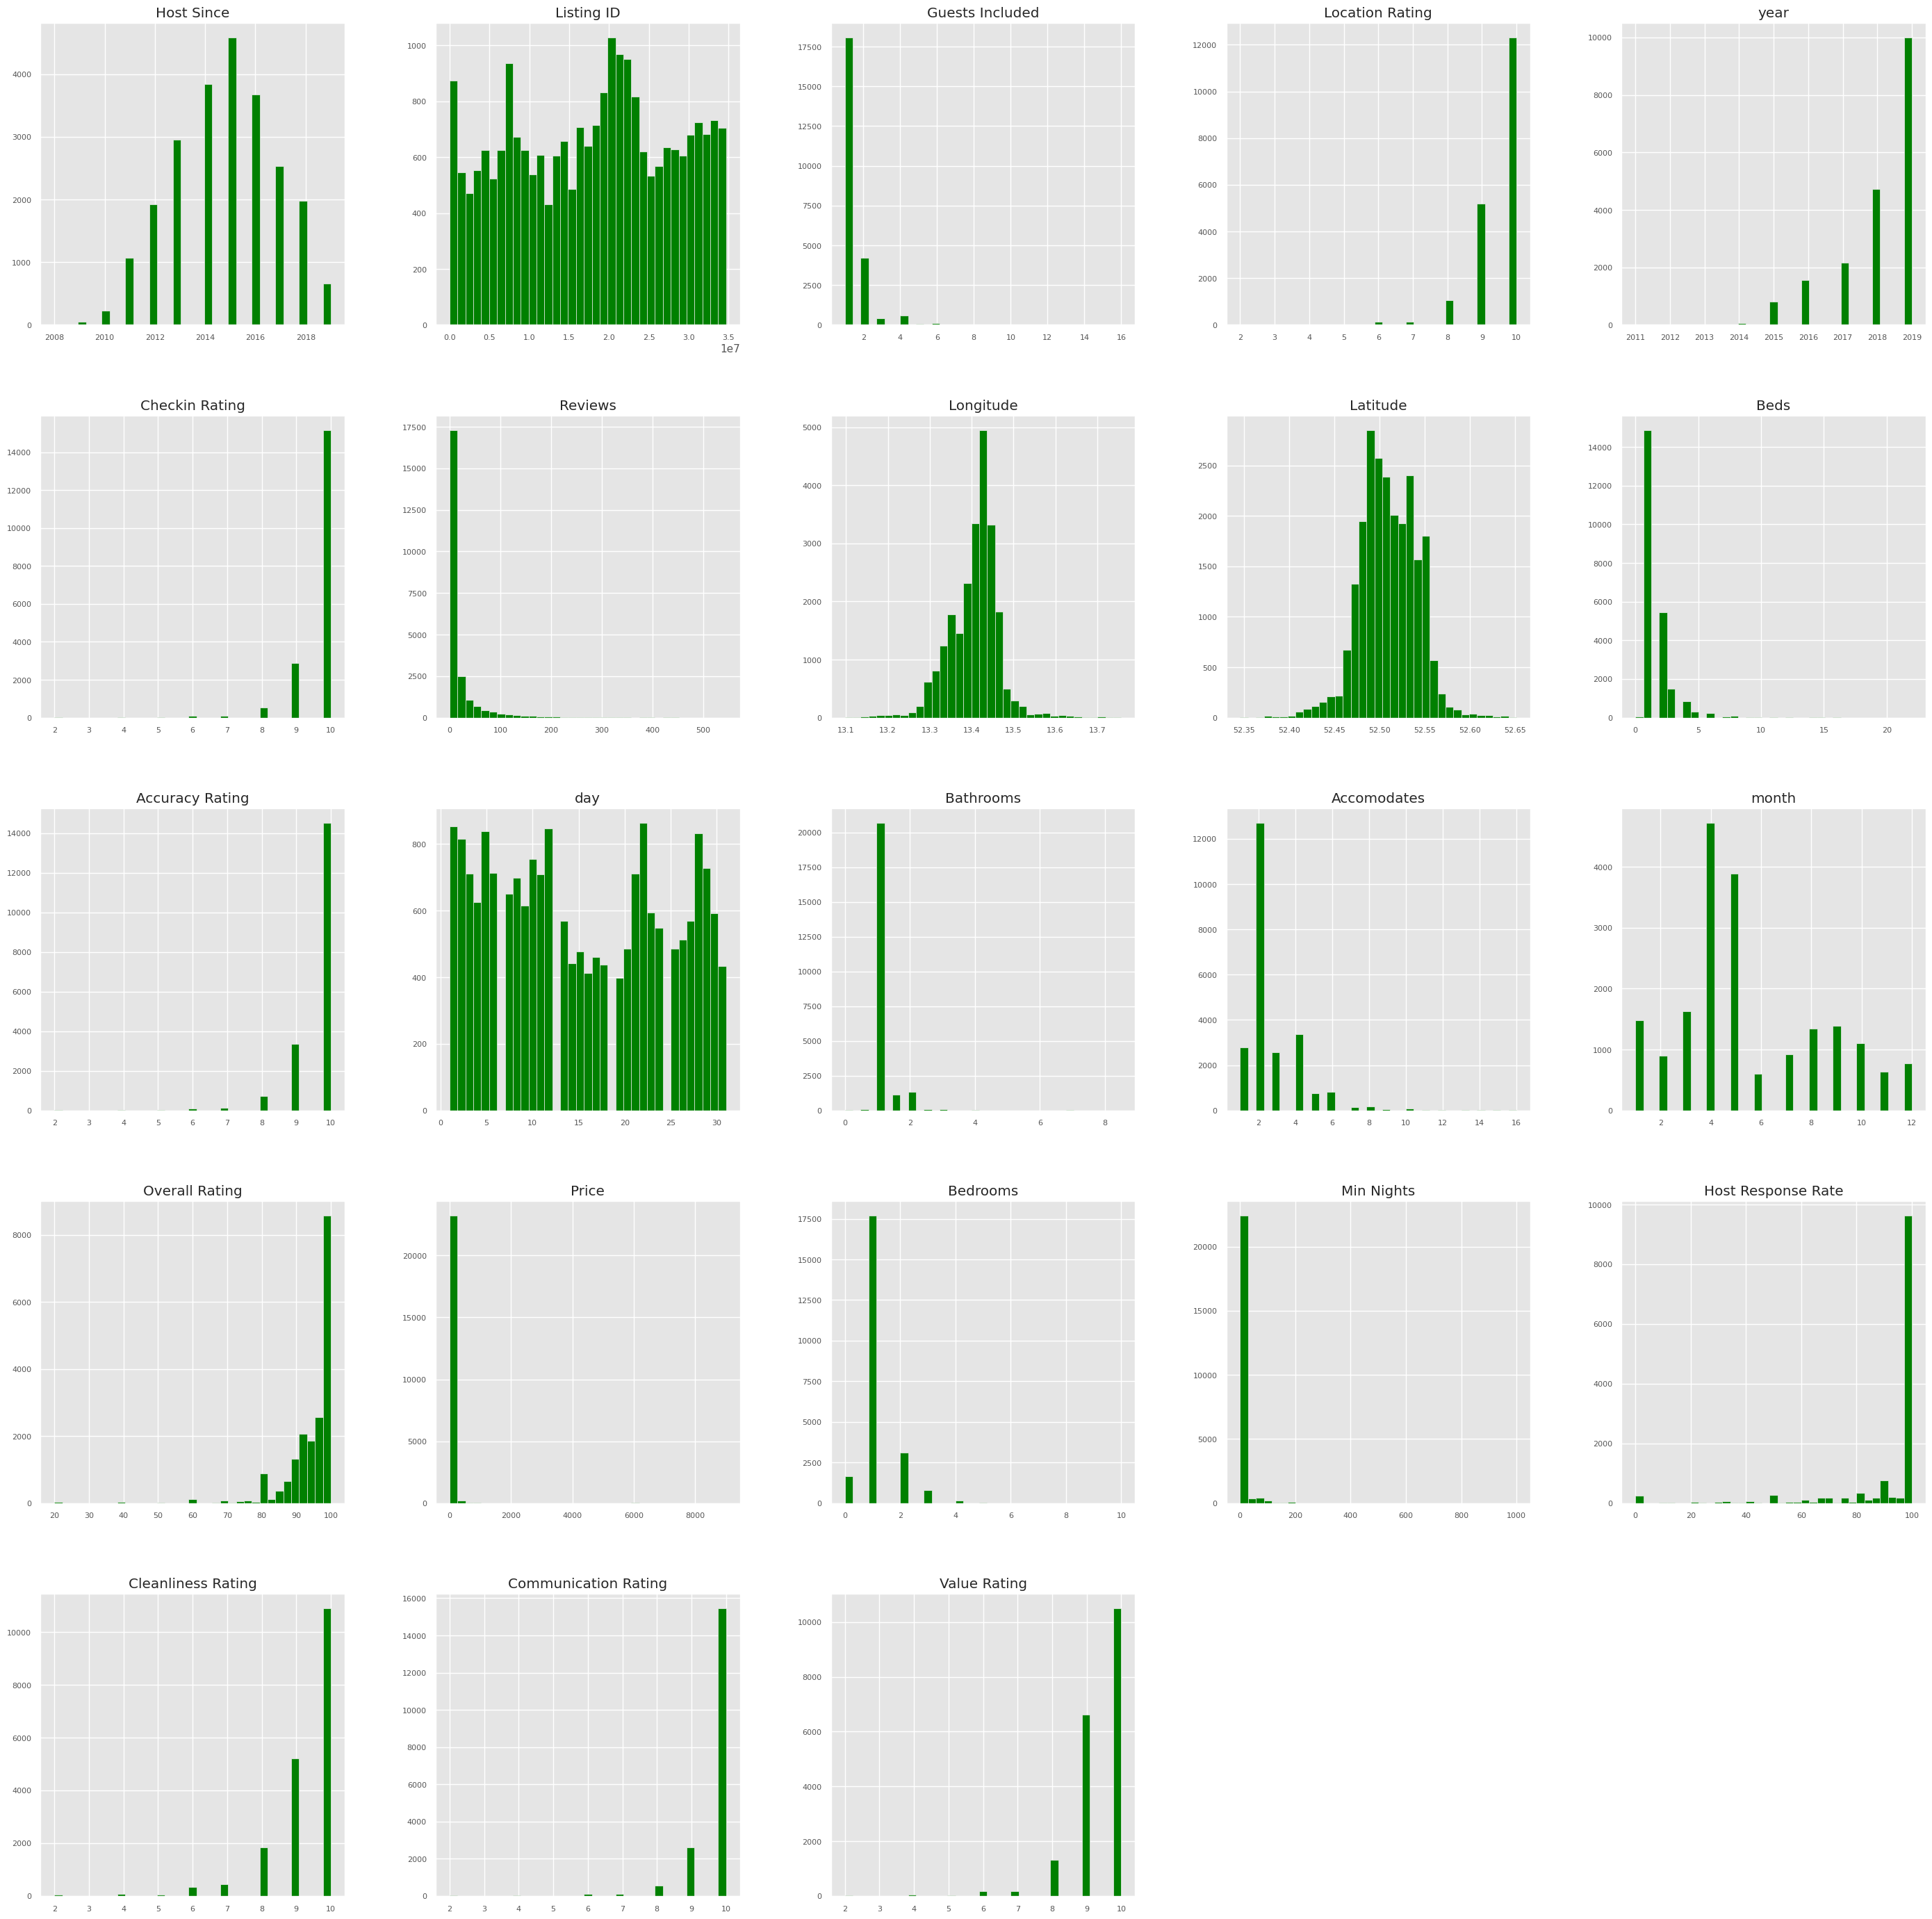

In [241]:
df_num_non_dummy.hist(figsize=(35, 35), bins=35, xlabelsize=8, ylabelsize=8, color = "green");

We can see that data is skewed, let's measure the asymmetry of the distribution:

In [242]:
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    #else
       # return default
pd.DataFrame(df_num_non_dummy.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

we can see in the pink all the columns are positively skewed (skewness > 1), 9 columns.

in the green we can see columns are negativley skewed (skewness < -1), 10 columns.

later we'll see if outliers or missing values can affect the features distribution.

In [243]:
for i in df_dummy.columns:
 print(i)




Is Superhost
Instant Bookable
Is Exact Location


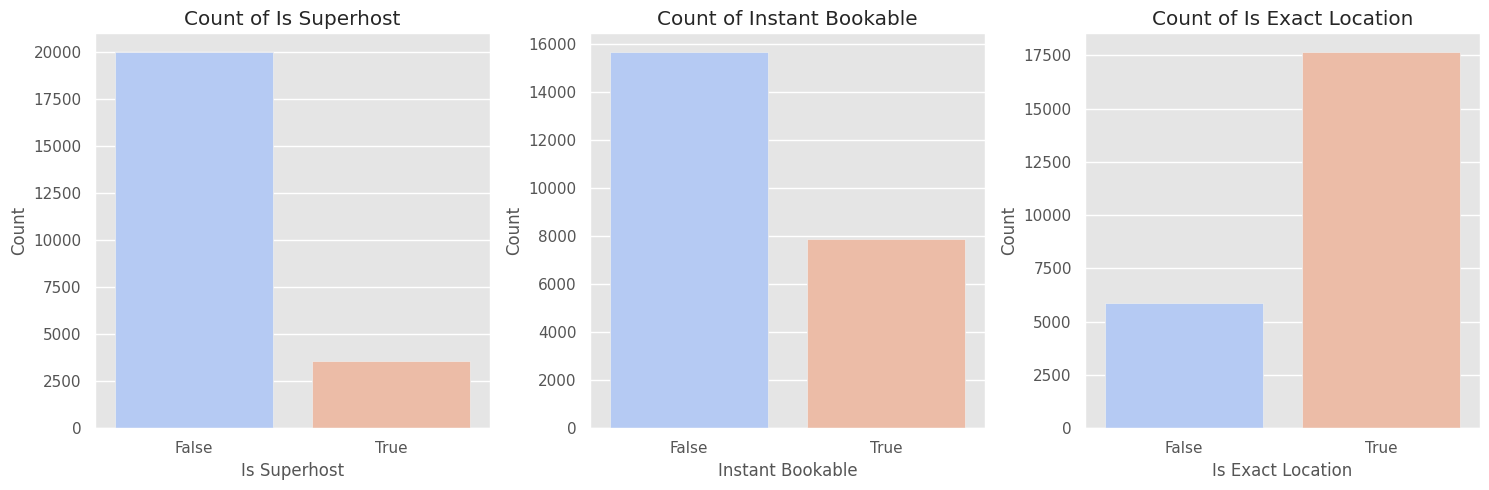

In [244]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each column and create a count plot
for i, col in enumerate(df_dummy.columns):
    sns.countplot(x=df_dummy[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [245]:
df_categorial

Host Response Time Host Response Rate Cleansed    neighbourhood  \
0            within a day                Low Response  Prenzlauer Berg   
1            within a day                Low Response  Prenzlauer Berg   
2          within an hour          Very High Response  Prenzlauer Berg   
3            within a day          Very High Response  Prenzlauer Berg   
4            within a day          Very High Response  Prenzlauer Berg   
...                   ...                         ...              ...   
23531  within a few hours           Moderate Response          Wannsee   
23532                None                         NaN            Mitte   
23533                None                         NaN            Britz   
23534                None                         NaN        KÃ¶penick   
23535                None                         NaN       WeiÃensee   

      Neighbourhood Grouped Cleansed        Room Type Postal Code Cleansed  \
0                             Pankow     Private room                   10   
1                             Pankow  Entire home/apt                   10   
2                             Pankow     Private room                   10   
3                             Pankow  Entire home/apt                   10   
4                             Pankow  Entire home/apt                   10   
...                              ...              ...                  ...   
23531          Steglitz - Zehlendorf  Entire home/apt                   14   
23532                          Mitte     Private room                   13   
23533                      NeukÃ¶lln     Private room                   12   
23534            Treptow - KÃ¶penick  Entire home/apt                   12   
23535                         Pankow  Entire home/apt                   13   

      Property Type Cleansed  
0                  Apartment  
1                  Apartment  
2                  Apartment  
3                  Apartment  
4                  Apartment  
...                      ...  
23531              Apartment  
23532              Apartment  
23533              Apartment  
23534              Apartment  
23535              Apartment  

[23536 rows x 7 columns]

In [246]:
df_categorial.shape

(23536, 7)

In [247]:
# a = 8  # number of rows
# b = 1  # number of columns
# c = 1  # plot counter

# fig = plt.figure(figsize=(50,80))
# plt.subplots_adjust(hspace = 0.1)
# sns.set(font_scale = 2.5)
# for i in df_categorial:
# #        plt.subplot(a, b, c)
#         plt.title('{}'.format(i))
#         plt.xlabel(i)
#         sns.countplot(df_categorial[i],palette="coolwarm")
#         c = c + 1

# plt.show()

In [248]:
df['Price'].describe()

count    23536.000000
mean        69.612424
std        216.660408
min          0.000000
25%         32.000000
50%         49.000000
75%         75.000000
max       9000.000000
Name: Price, dtype: float64

we can aee that max price is  9000, but the 75% quantile is 75 ,
so we need to remove the extream values during the outliers phase

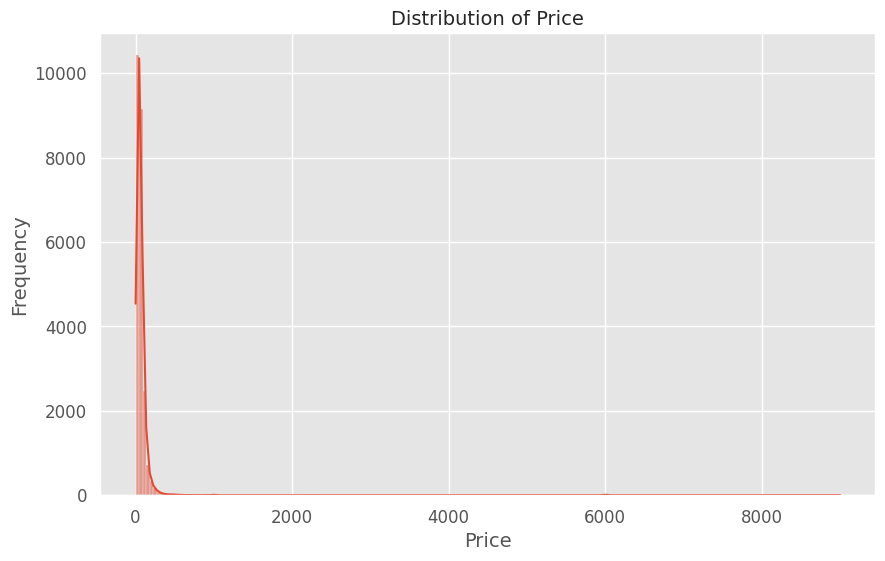

In [249]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=200, kde=True )
plt.title("Distribution of Price",fontsize=14)
plt.xlabel("Price",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.show()

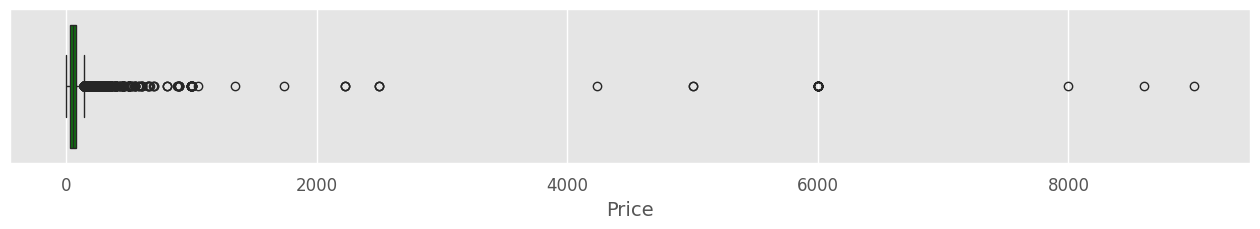

In [250]:
plt.figure(figsize=(16, 2))
sns.boxplot(df['Price'], orient='h',color='green')
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.xlabel("Price",fontsize=14)
plt.show()

In [251]:
df.head()
# corr = df.corr(method = 'spearman')
# corr.style.background_gradient(cmap='coolwarm').set_precision(4)

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0        2695           100.0             10.0                10.0   
1        3176            92.0              9.0                 9.0   
2        7071            96.0             10.0                10.0   
3        9991           100.0             10.0                10.0   
4       14325            93.0             10.0                10.0   

   Checkin Rating  Communication Rating  Location Rating  Value Rating  Price  \
0            10.0                  10.0              9.0          10.0   17.0   
1             9.0                   9.0             10.0           9.0   90.0   
2            10.0                  10.0             10.0          10.0   33.0   
3            10.0                  10.0             10.0          10.0  180.0   
4             9.0                  10.0              9.0           9.0   70.0   

   Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  Is Superhost  \
0      7.0       1.0   1.0        1.0                50.0         False   
1    144.0       1.0   2.0        1.0                50.0         False   
2    229.0       1.0   2.0        1.0               100.0          True   
3      6.0       4.0   7.0        2.5               100.0         False   
4     23.0       0.0   1.0        1.0               100.0         False   

   Latitude  Longitude  Accomodates  Guests Included  Min Nights  \
0  52.54851   13.40455            2                1           2   
1  52.53500   13.41758            4                2          62   
2  52.54316   13.41509            2                1           2   
3  52.53303   13.41605            7                5           6   
4  52.54785   13.40556            1                1          90   

   Instant Bookable  Host Since  Is Exact Location Host Response Time  \
0             False      2008.0               True       within a day   
1             False      2008.0               True       within a day   
2             False      2009.0               True     within an hour   
3             False      2009.0              False       within a day   
4             False      2009.0               True       within a day   

     neighbourhood        Room Type Host Response Rate Cleansed  \
0  Prenzlauer Berg     Private room                Low Response   
1  Prenzlauer Berg  Entire home/apt                Low Response   
2  Prenzlauer Berg     Private room          Very High Response   
3  Prenzlauer Berg  Entire home/apt          Very High Response   
4  Prenzlauer Berg  Entire home/apt          Very High Response   

  Neighbourhood Grouped Cleansed Property Type Cleansed Postal Code Cleansed  \
0                         Pankow              Apartment                   10   
1                         Pankow              Apartment                   10   
2                         Pankow              Apartment                   10   
3                         Pankow              Apartment                   10   
4                         Pankow              Apartment                   10   

     year  month   day  
0  2019.0    4.0  21.0  
1  2018.0   10.0  29.0  
2  2019.0    5.0   8.0  
3  2018.0    7.0  23.0  
4  2018.0   11.0   1.0

### Missing values

Dataframe containing missing value counts and their frequency:

In [252]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Host Response Rate             10490               44.6
Value Rating                    4668               19.8
Checkin Rating                  4666               19.8
Location Rating                 4665               19.8
Communication Rating            4650               19.8
Accuracy Rating                 4648               19.7
Cleanliness Rating              4644               19.7
Overall Rating                  4622               19.6
year                            4156               17.7
month                           4156               17.7
day                             4156               17.7
Beds                              35                0.1
Bathrooms                         29                0.1
Host Since                        21                0.1
Bedrooms                          20                0.1

Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [253]:
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
count     23536.0    23536.000000     23536.000000        23536.000000   
mean          0.0        0.196380         0.197485            0.197315   
std           0.0        0.397268         0.398110            0.397980   
min           0.0        0.000000         0.000000            0.000000   
25%           0.0        0.000000         0.000000            0.000000   
50%           0.0        0.000000         0.000000            0.000000   
75%           0.0        0.000000         0.000000            0.000000   
max           0.0        1.000000         1.000000            1.000000   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
count    23536.000000          23536.000000     23536.000000  23536.000000   
mean         0.198249              0.197570         0.198207      0.198334   
std          0.398690              0.398174         0.398657      0.398754   
min          0.000000              0.000000         0.000000      0.000000   
25%          0.000000              0.000000         0.000000      0.000000   
50%          0.000000              0.000000         0.000000      0.000000   
75%          0.000000              0.000000         0.000000      0.000000   
max          1.000000              1.000000         1.000000      1.000000   

         Price  Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.0  23536.0  23536.000000  23536.000000  23536.000000   
mean       0.0      0.0      0.000850      0.001487      0.001232   
std        0.0      0.0      0.029139      0.038535      0.035081   
min        0.0      0.0      0.000000      0.000000      0.000000   
25%        0.0      0.0      0.000000      0.000000      0.000000   
50%        0.0      0.0      0.000000      0.000000      0.000000   
75%        0.0      0.0      0.000000      0.000000      0.000000   
max        0.0      0.0      1.000000      1.000000      1.000000   

       Host Response Rate  Is Superhost  Latitude  Longitude  Accomodates  \
count        23536.000000       23536.0   23536.0    23536.0      23536.0   
mean             0.445700           0.0       0.0        0.0          0.0   
std              0.497053           0.0       0.0        0.0          0.0   
min              0.000000           0.0       0.0        0.0          0.0   
25%              0.000000           0.0       0.0        0.0          0.0   
50%              0.000000           0.0       0.0        0.0          0.0   
75%              1.000000           0.0       0.0        0.0          0.0   
max              1.000000           0.0       0.0        0.0          0.0   

       Guests Included  Min Nights  Instant Bookable    Host Since  \
count          23536.0     23536.0           23536.0  23536.000000   
mean               0.0         0.0               0.0      0.000892   
std                0.0         0.0               0.0      0.029858   
min                0.0         0.0               0.0      0.000000   
25%                0.0         0.0               0.0      0.000000   
50%                0.0         0.0               0.0      0.000000   
75%                0.0         0.0               0.0      0.000000   
max                0.0         0.0               0.0      1.000000   

       Is Exact Location  Host Response Time  neighbourhood  Room Type  \
count            23536.0        23536.000000        23536.0    23536.0   
mean                 0.0            0.445700            0.0        0.0   
std                  0.0            0.497053            0.0        0.0   
min                  0.0            0.000000            0.0        0.0   
25%                  0.0            0.000000            0.0        0.0   
50%                  0.0            0.000000            0.0        0.0   
75%                  0.0            1.000000            0.0        0.0   
max                  0.0            1.000000            0.0        0.0   

       Host Response Ra

### Catigories

In [254]:
df_categorial.describe().T

count unique                       top   freq
Host Response Time              13046      4            within an hour   6816
Host Response Rate Cleansed     13046      4        Very High Response   9752
neighbourhood                   23536     93                 NeukÃ¶lln   3444
Neighbourhood Grouped Cleansed  23536     12  Friedrichshain-Kreuzberg   5718
Room Type                       23536      3              Private room  11694
Postal Code Cleansed            23536      8                        10  14667
Property Type Cleansed          23536     15                 Apartment  20935

In [255]:
# i = 1
# plt.figure(figsize=(40, 40))
# plt.subplots_adjust(hspace = 0.5)
# for col in df_categorial.columns:
#   plt.subplot(5, 2, i)
#   plt.title(f"Distribution of `{col}`", fontsize=12, fontweight="bold")
#   plt.xlabel(col, fontsize=10)
#   plt.xticks(rotation=50, fontsize=14)
#   plt.ylabel("Count")
#   sns.countplot(data=df, x=col, palette="plasma")
#   i = i + 1

# plt.tight_layout()
# plt.show()

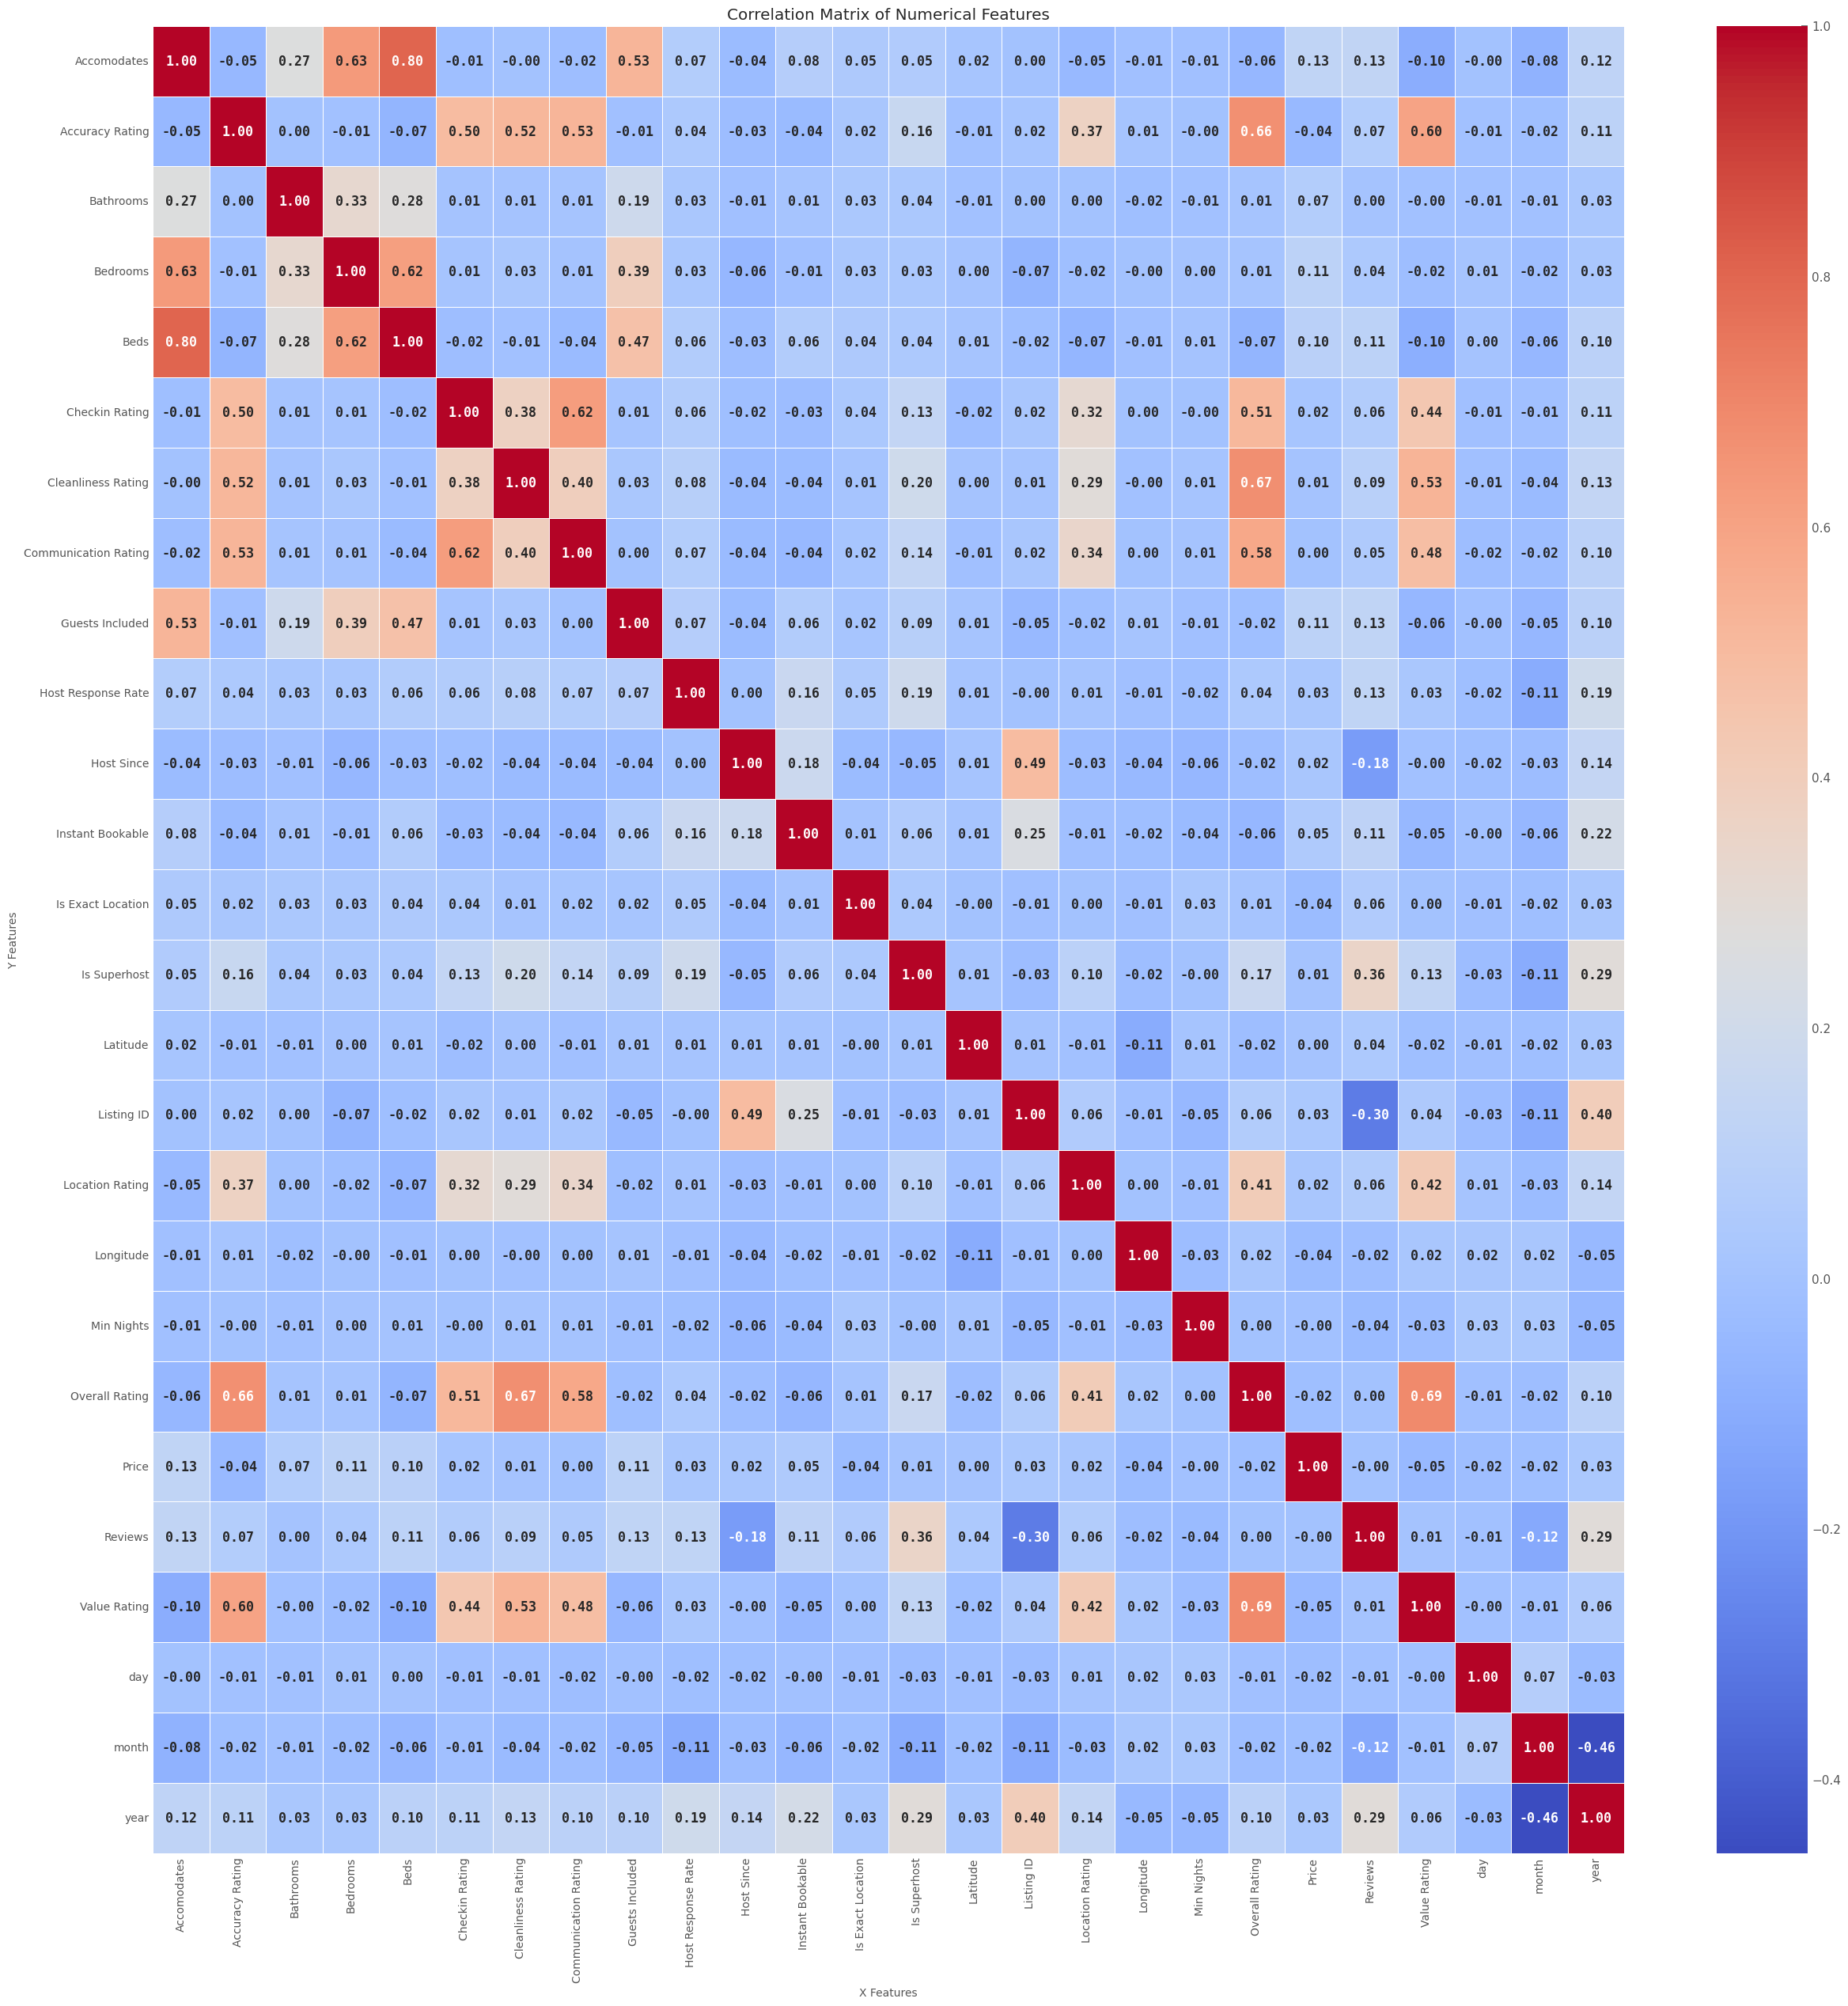

In [256]:
plt.style.use('bmh')
plt.figure(figsize=(30, 30))
correlation_matrix = df[df_num.union(df_dummy.columns)].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5 , annot_kws={"size": 12, "weight": "bold", "family": "monospace"})
plt.xlabel("X Features", fontsize=10)
plt.ylabel("Y Features", fontsize=10)
plt.title("Heatmap Example", fontsize=10)
plt.title("Correlation Matrix of Numerical Features")
plt.tick_params(axis='both', labelsize=10)
plt.show()

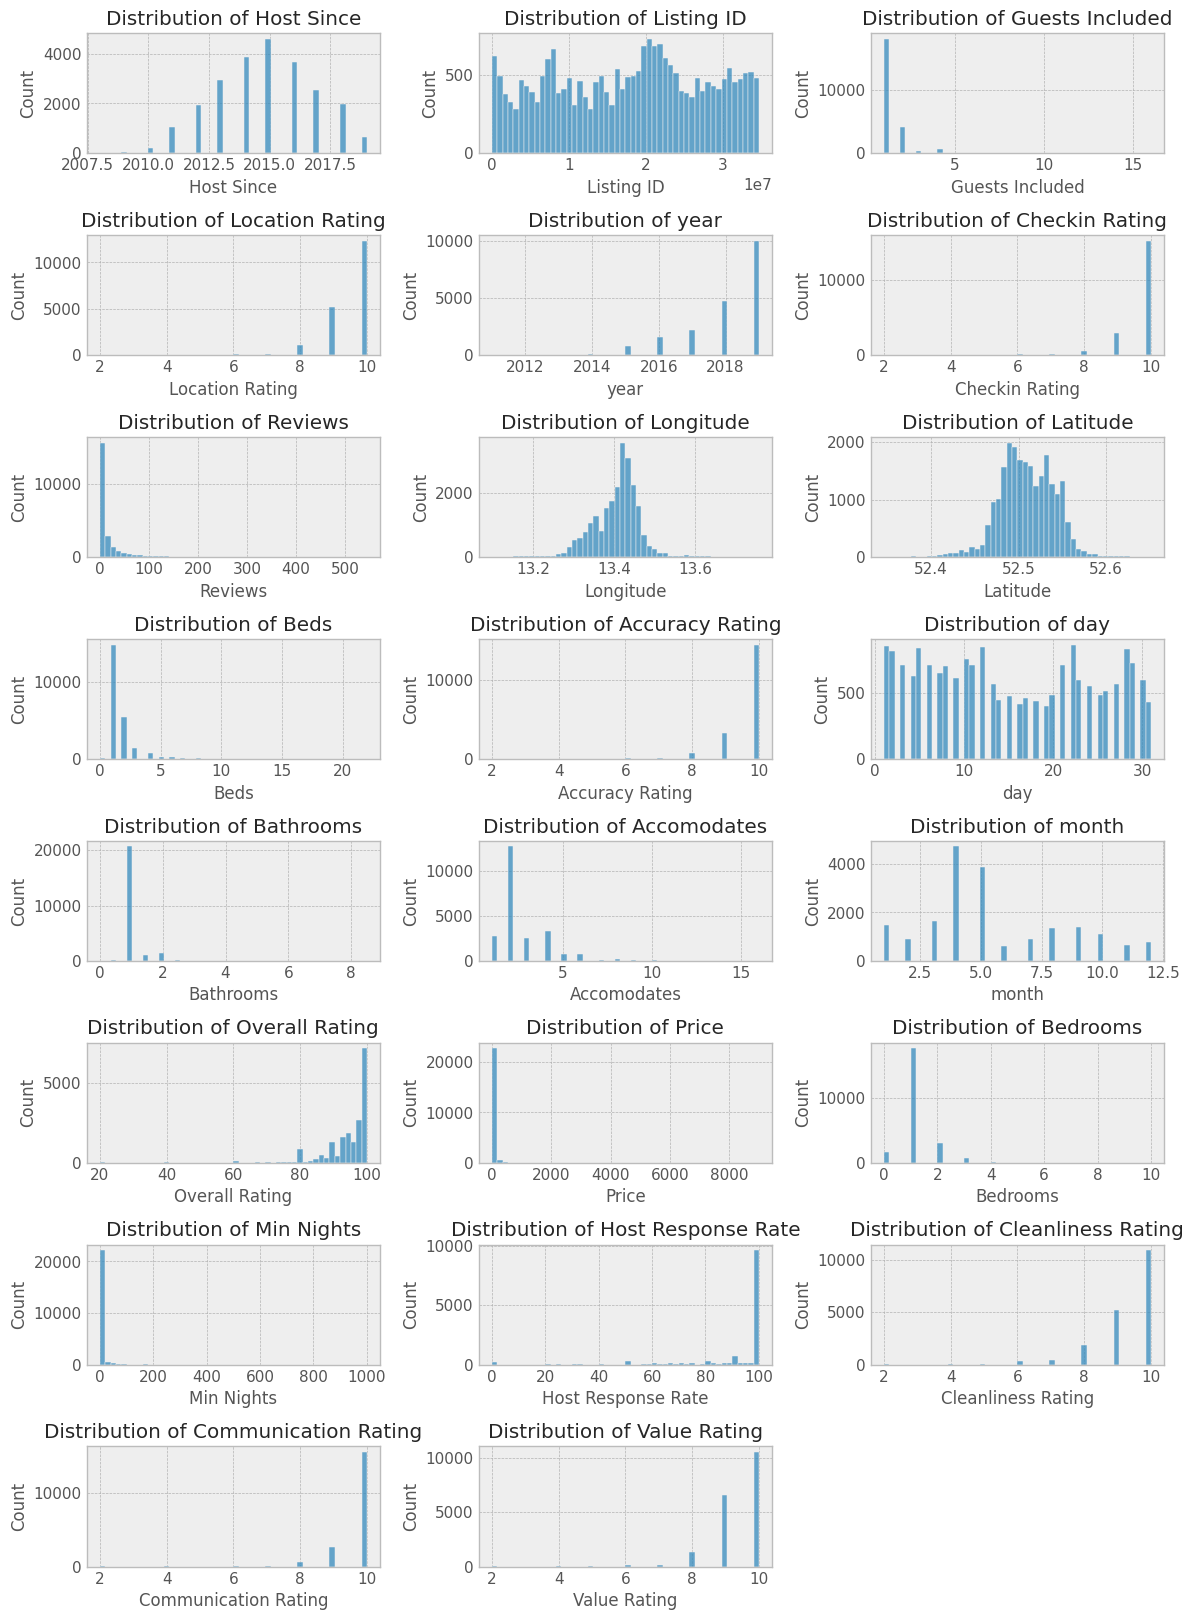

In [257]:
plt.figure(figsize=(12, 30))
plt.subplots_adjust(hspace = 0.5)
for i, col in enumerate(df_num_non_dummy, 1):
  plt.subplot(15, 3, i)
  sns.histplot(df[col].dropna(), bins=50, kde=False)
  plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

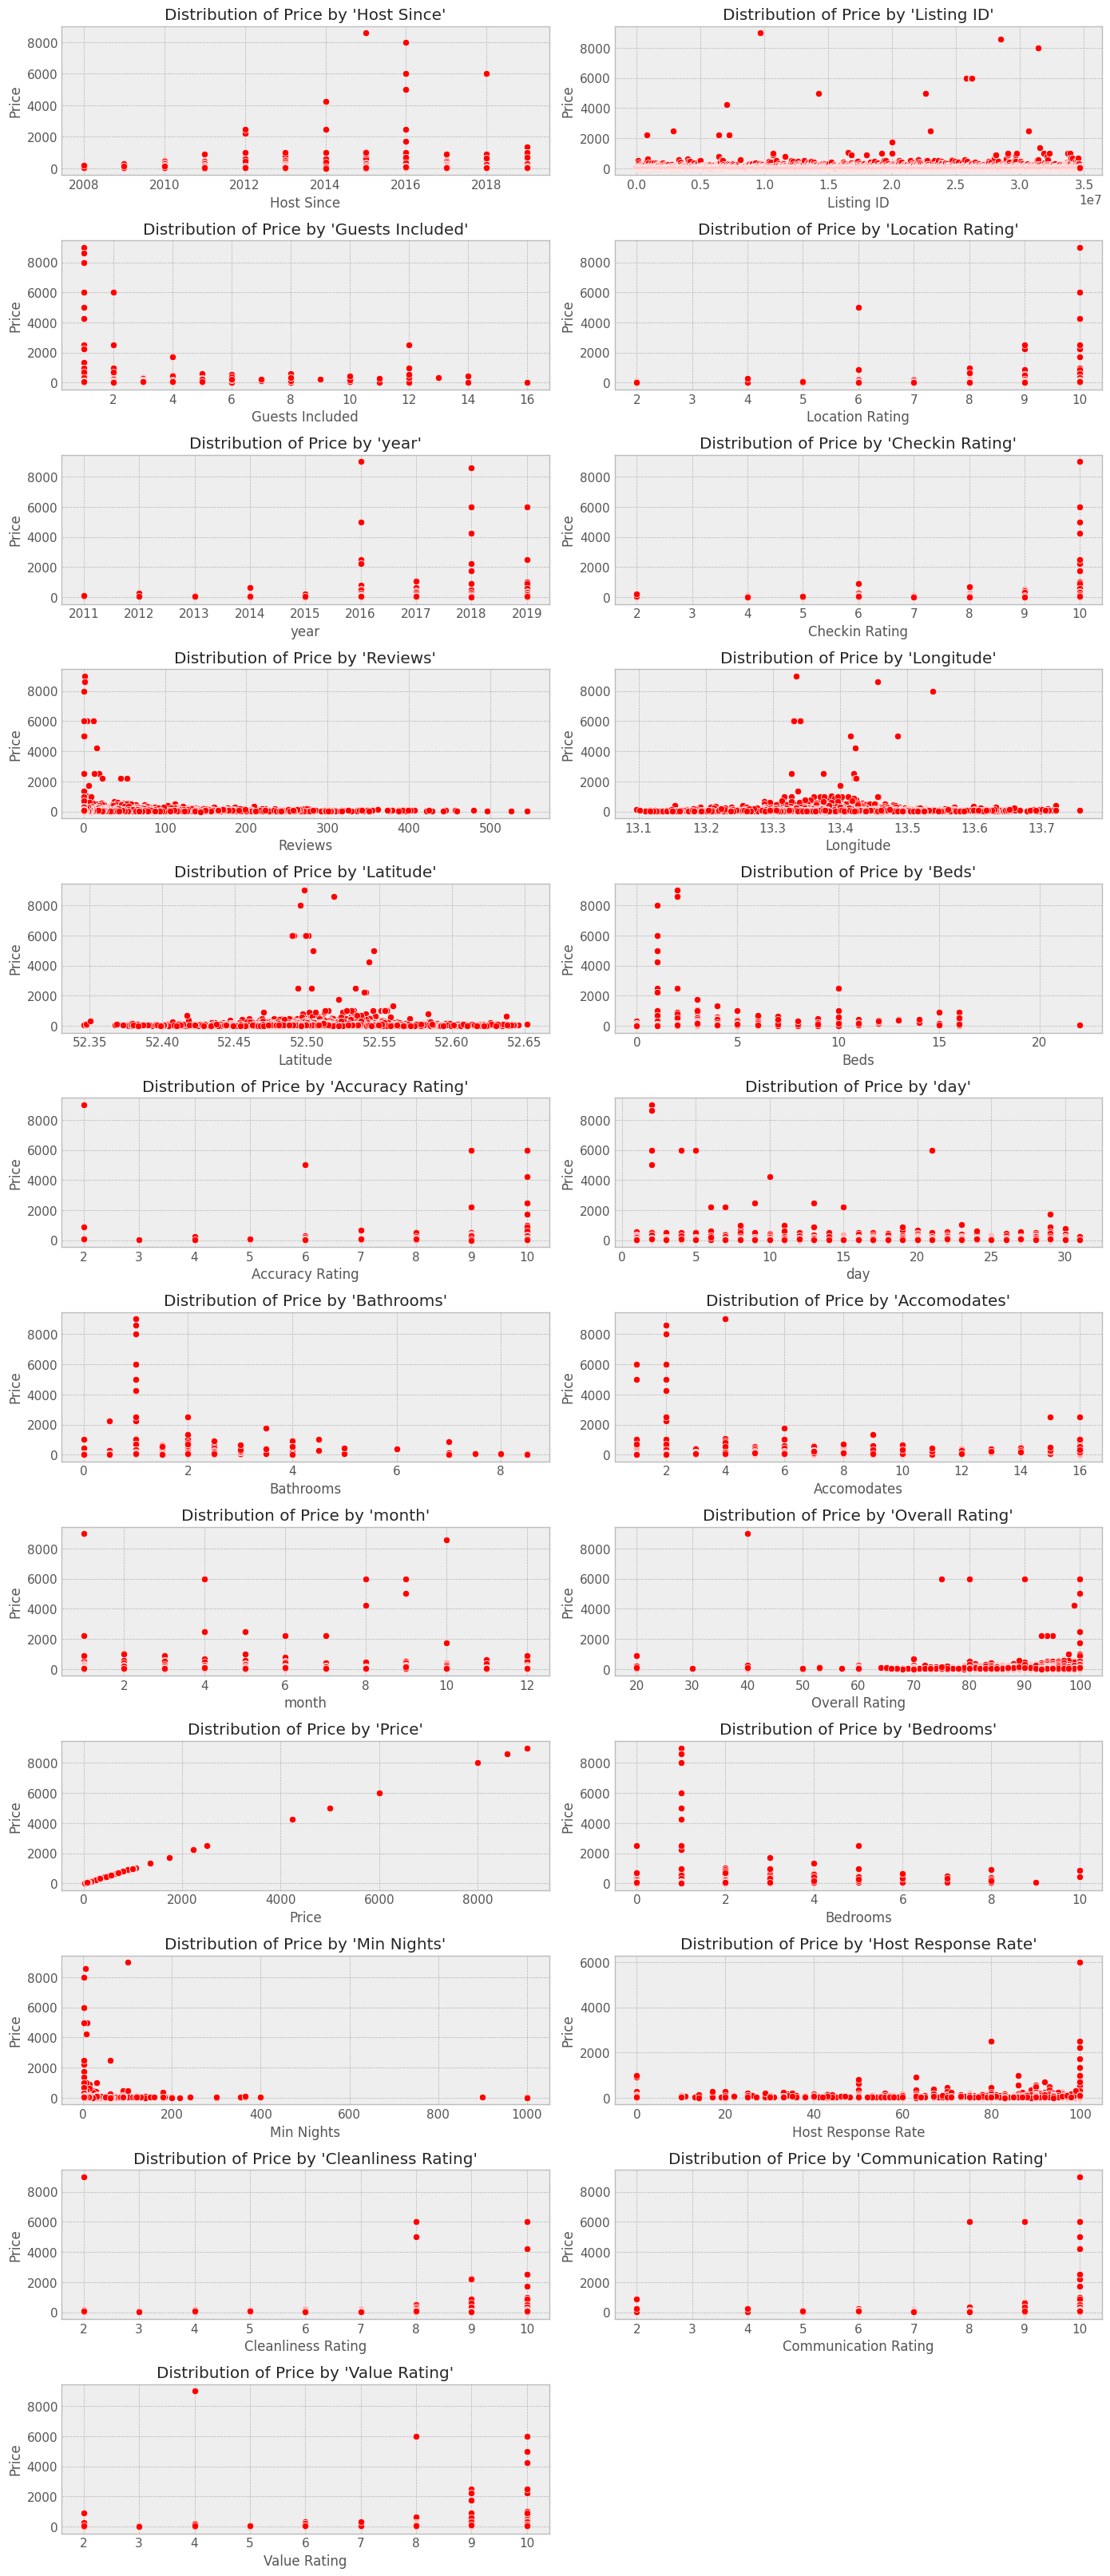

In [258]:
bar_plot_columns = ['Bedrooms', 'Bathrooms', 'Beds']
plt.figure(figsize=(14, 40))
plt.subplots_adjust(hspace = 0.5)
i = 1
for col in df_num_non_dummy.columns:
  plt.subplot(15, 2, i)
  sns.scatterplot(x=df[col], y=df['Price'], color='red')
  plt.title(f"Distribution of Price by '{col}'")

  # plt.subplot(3, 2, i+1)
  # sns.barplot(x=df[col], y=df['Price'], errcolor="red")
  # plt.title(f"Distribution of Price by '{col}'")
  # plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=2)
  # plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=2)

  i = i + 1
plt.tight_layout()
plt.show()

In [259]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df_categorial:
  df[f"{col} Encoded"] = le.fit_transform(df[col])

df.drop(columns=df_categorial.columns, inplace=True)
df.head()


Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0        2695           100.0             10.0                10.0   
1        3176            92.0              9.0                 9.0   
2        7071            96.0             10.0                10.0   
3        9991           100.0             10.0                10.0   
4       14325            93.0             10.0                10.0   

   Checkin Rating  Communication Rating  Location Rating  Value Rating  Price  \
0            10.0                  10.0              9.0          10.0   17.0   
1             9.0                   9.0             10.0           9.0   90.0   
2            10.0                  10.0             10.0          10.0   33.0   
3            10.0                  10.0             10.0          10.0  180.0   
4             9.0                  10.0              9.0           9.0   70.0   

   Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  Is Superhost  \
0      7.0       1.0   1.0        1.0                50.0         False   
1    144.0       1.0   2.0        1.0                50.0         False   
2    229.0       1.0   2.0        1.0               100.0          True   
3      6.0       4.0   7.0        2.5               100.0         False   
4     23.0       0.0   1.0        1.0               100.0         False   

   Latitude  Longitude  Accomodates  Guests Included  Min Nights  \
0  52.54851   13.40455            2                1           2   
1  52.53500   13.41758            4                2          62   
2  52.54316   13.41509            2                1           2   
3  52.53303   13.41605            7                5           6   
4  52.54785   13.40556            1                1          90   

   Instant Bookable  Host Since  Is Exact Location    year  month   day  \
0             False      2008.0               True  2019.0    4.0  21.0   
1             False      2008.0               True  2018.0   10.0  29.0   
2             False      2009.0               True  2019.0    5.0   8.0   
3             False      2009.0              False  2018.0    7.0  23.0   
4             False      2009.0               True  2018.0   11.0   1.0   

   Host Response Time Encoded  Host Response Rate Cleansed Encoded  \
0                           1                                    1   
1                           1                                    1   
2                           3                                    3   
3                           1                                    3   
4                           1                                    3   

   neighbourhood Encoded  Neighbourhood Grouped Cleansed Encoded  \
0                     65                                       6   
1                     65                                       6   
2                     65                                       6   
3                     65                                       6   
4                     65                                       6   

   Room Type Encoded  Postal Code Cleansed Encoded  \
0                  1                             0   
1                  0                             0   
2                  1                             0   
3                  0                             0   
4                  0                             0   

   Property Type Cleansed Encoded  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0

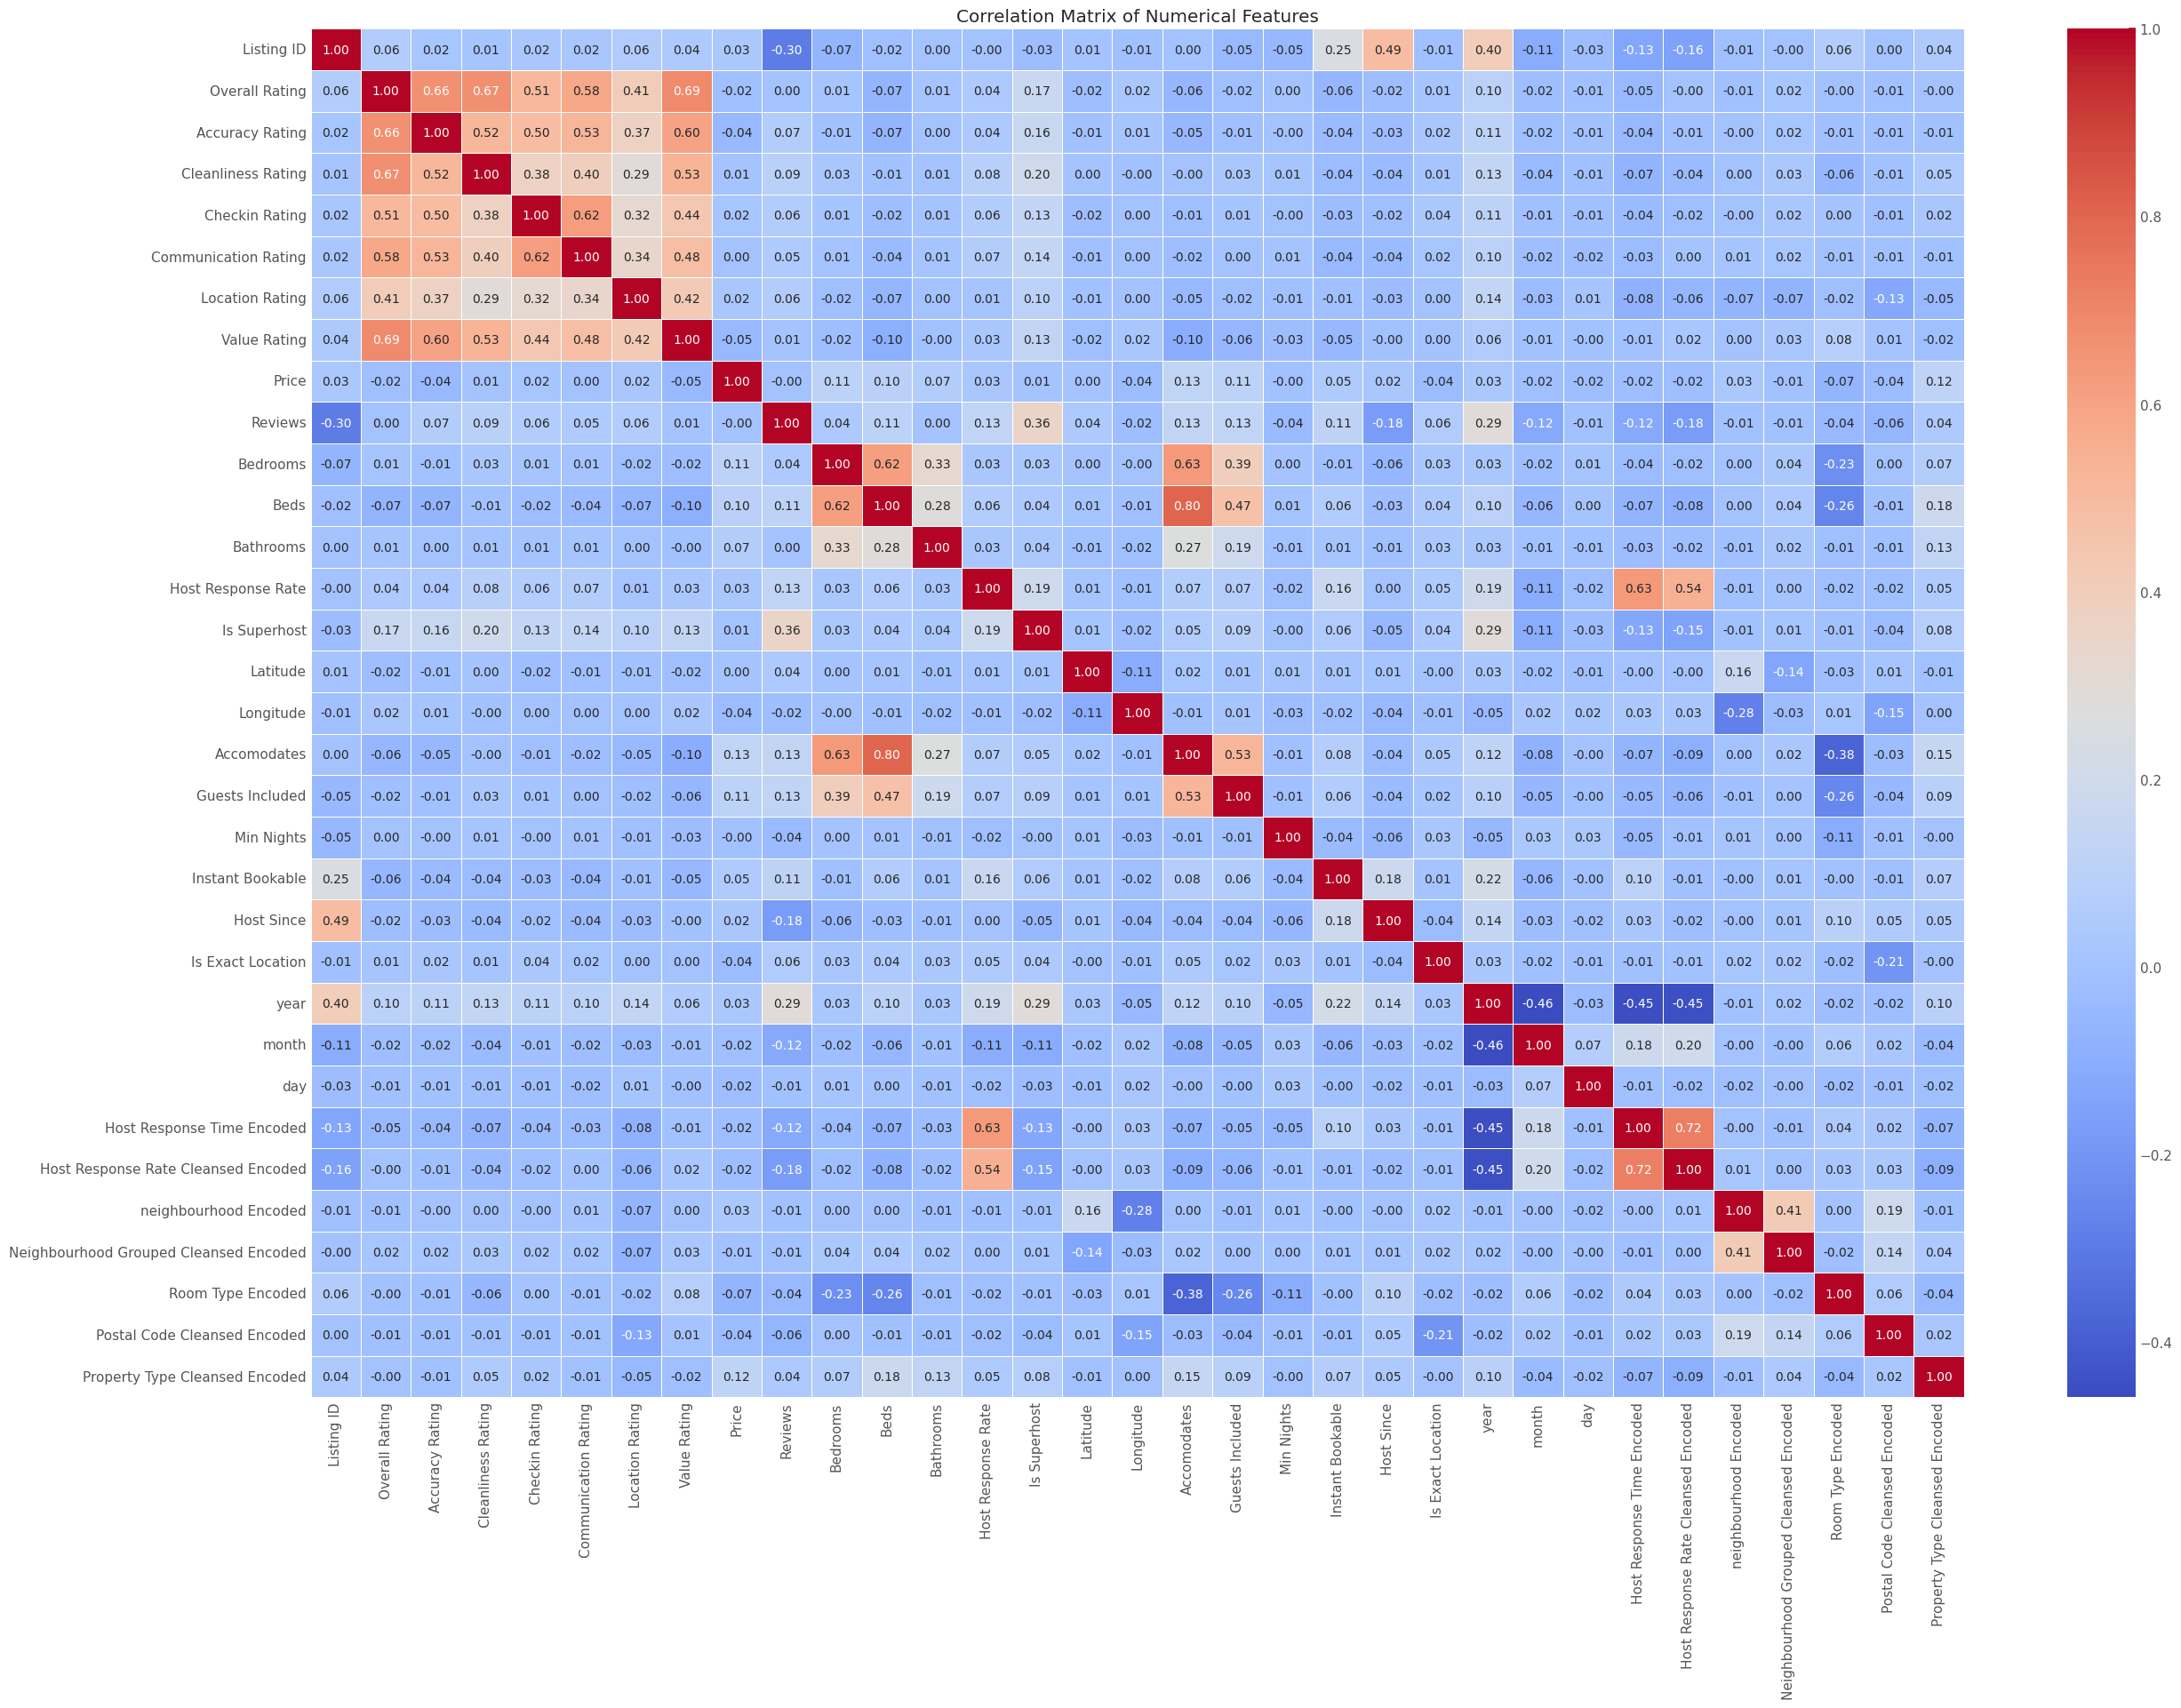

In [260]:
plt.figure(figsize=(30, 20))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [261]:
corr = df.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm')

In [262]:
from scipy import stats
df_corr= pd.DataFrame(columns=('v1','v2','abscorr','origcorr','pval'))

for i in df_num:
        for j in df_num:
                if i > j:
                        a=stats.spearmanr(df[i], df[j],nan_policy='omit')
                        b="{}/{}".format(i,j)
                        df_corr.loc[b] =[i,j,abs(a[0]),a[0],a[1]]

df_corr_filtered= df_corr.loc[(df_corr['abscorr']>0.7 ) & (df_corr['pval']<0.05)]
df_corr_filtered.sort_values(by=['abscorr'],ascending=False)

v1           v2   abscorr  origcorr  pval
Beds/Accomodates  Beds  Accomodates  0.718802  0.718802   0.0

### Outliers


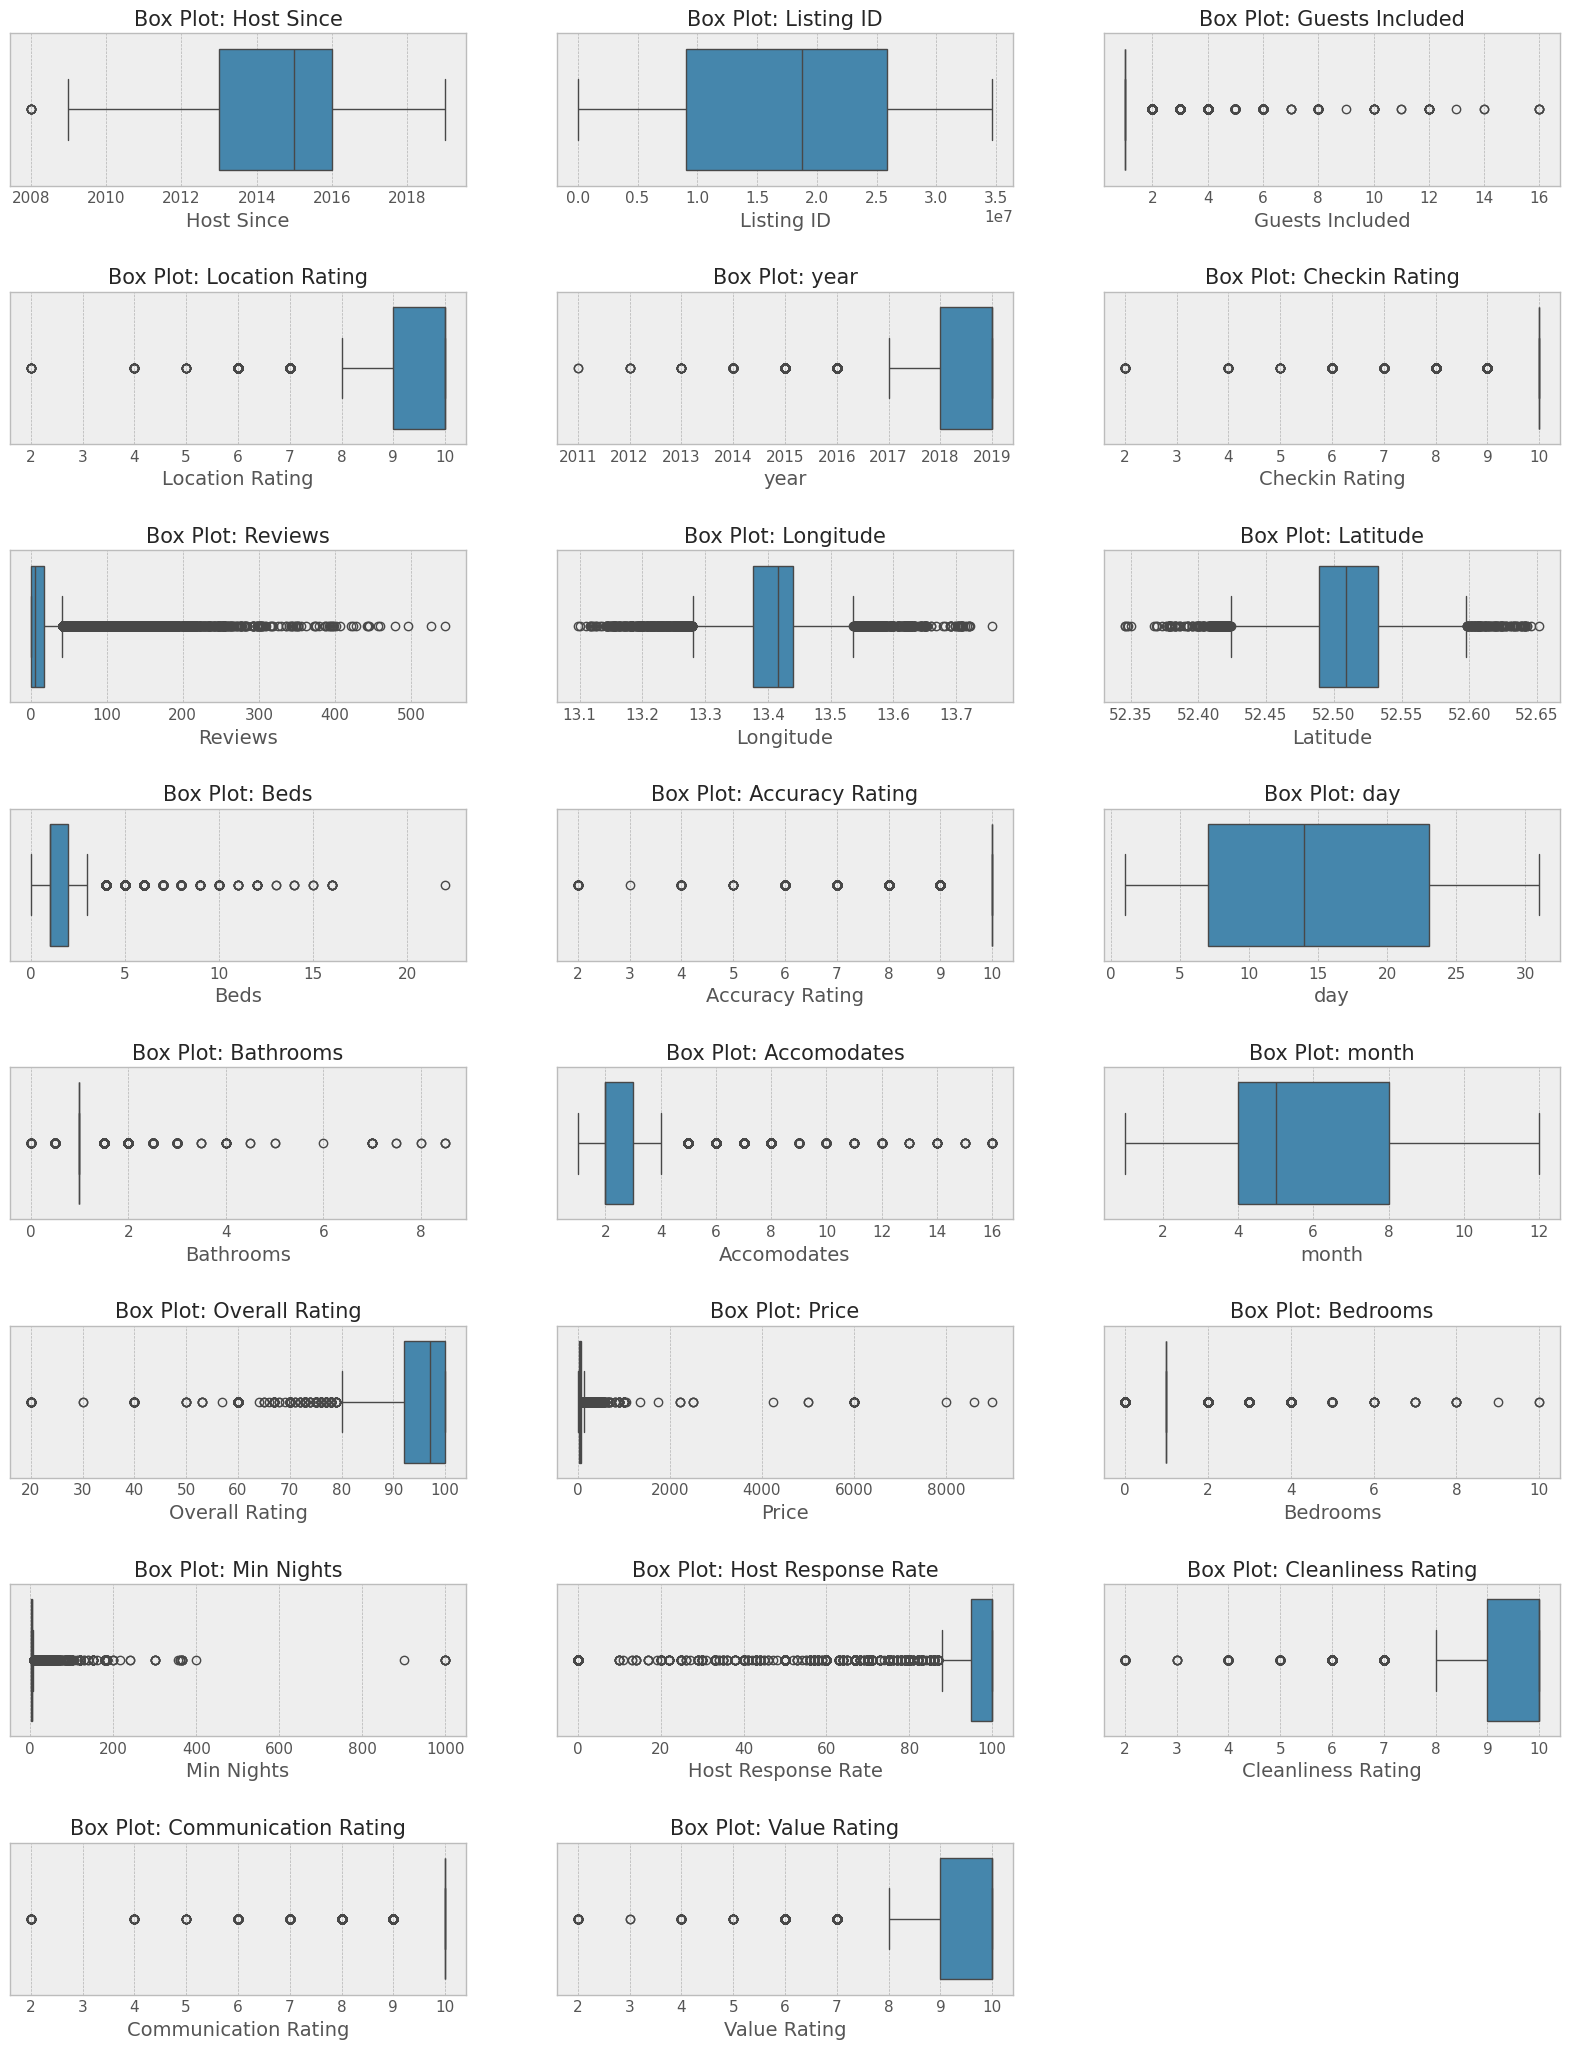

In [263]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'host_is_superhost':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df_num_non_dummy)

### Missing values

In [264]:
df_nulls = df.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

Overall Rating  Accuracy Rating  Cleanliness Rating  Checkin Rating  \
0               100.0             10.0                10.0            10.0   
1                92.0              9.0                 9.0             9.0   
2                96.0             10.0                10.0            10.0   
3               100.0             10.0                10.0            10.0   
4                93.0             10.0                10.0             9.0   
...               ...              ...                 ...             ...   
23531             NaN              NaN                 NaN             NaN   
23532             NaN              NaN                 NaN             NaN   
23533             NaN              NaN                 NaN             NaN   
23534             NaN              NaN                 NaN             NaN   
23535             NaN              NaN                 NaN             NaN   

       Communication Rating  Location Rating  Value Rating  Bedrooms  Beds  \
0                      10.0              9.0          10.0       1.0   1.0   
1                       9.0             10.0           9.0       1.0   2.0   
2                      10.0             10.0          10.0       1.0   2.0   
3                      10.0             10.0          10.0       4.0   7.0   
4                      10.0              9.0           9.0       0.0   1.0   
...                     ...              ...           ...       ...   ...   
23531                   NaN              NaN           NaN       1.0   2.0   
23532                   NaN              NaN           NaN       2.0   2.0   
23533                   NaN              NaN           NaN       1.0   1.0   
23534                   NaN              NaN           NaN       3.0   4.0   
23535                   NaN              NaN           NaN       2.0   2.0   

       Bathrooms  Host Response Rate  Host Since    year  month   day  
0            1.0                50.0      2008.0  2019.0    4.0  21.0  
1            1.0                50.0      2008.0  2018.0   10.0  29.0  
2            1.0               100.0      2009.0  2019.0    5.0   8.0  
3            2.5               100.0      2009.0  2018.0    7.0  23.0  
4            1.0               100.0      2009.0  2018.0   11.0   1.0  
...          ...                 ...         ...     ...    ...   ...  
23531        1.0                75.0      2018.0     NaN    NaN   NaN  
23532        1.0                 NaN      2019.0     NaN    NaN   NaN  
23533        1.5                 NaN      2014.0     NaN    NaN   NaN  
23534        1.0                 NaN      2019.0     NaN    NaN   NaN  
23535        1.0                 NaN      2018.0     NaN    NaN   NaN  

[23536 rows x 15 columns]

<Axes: >

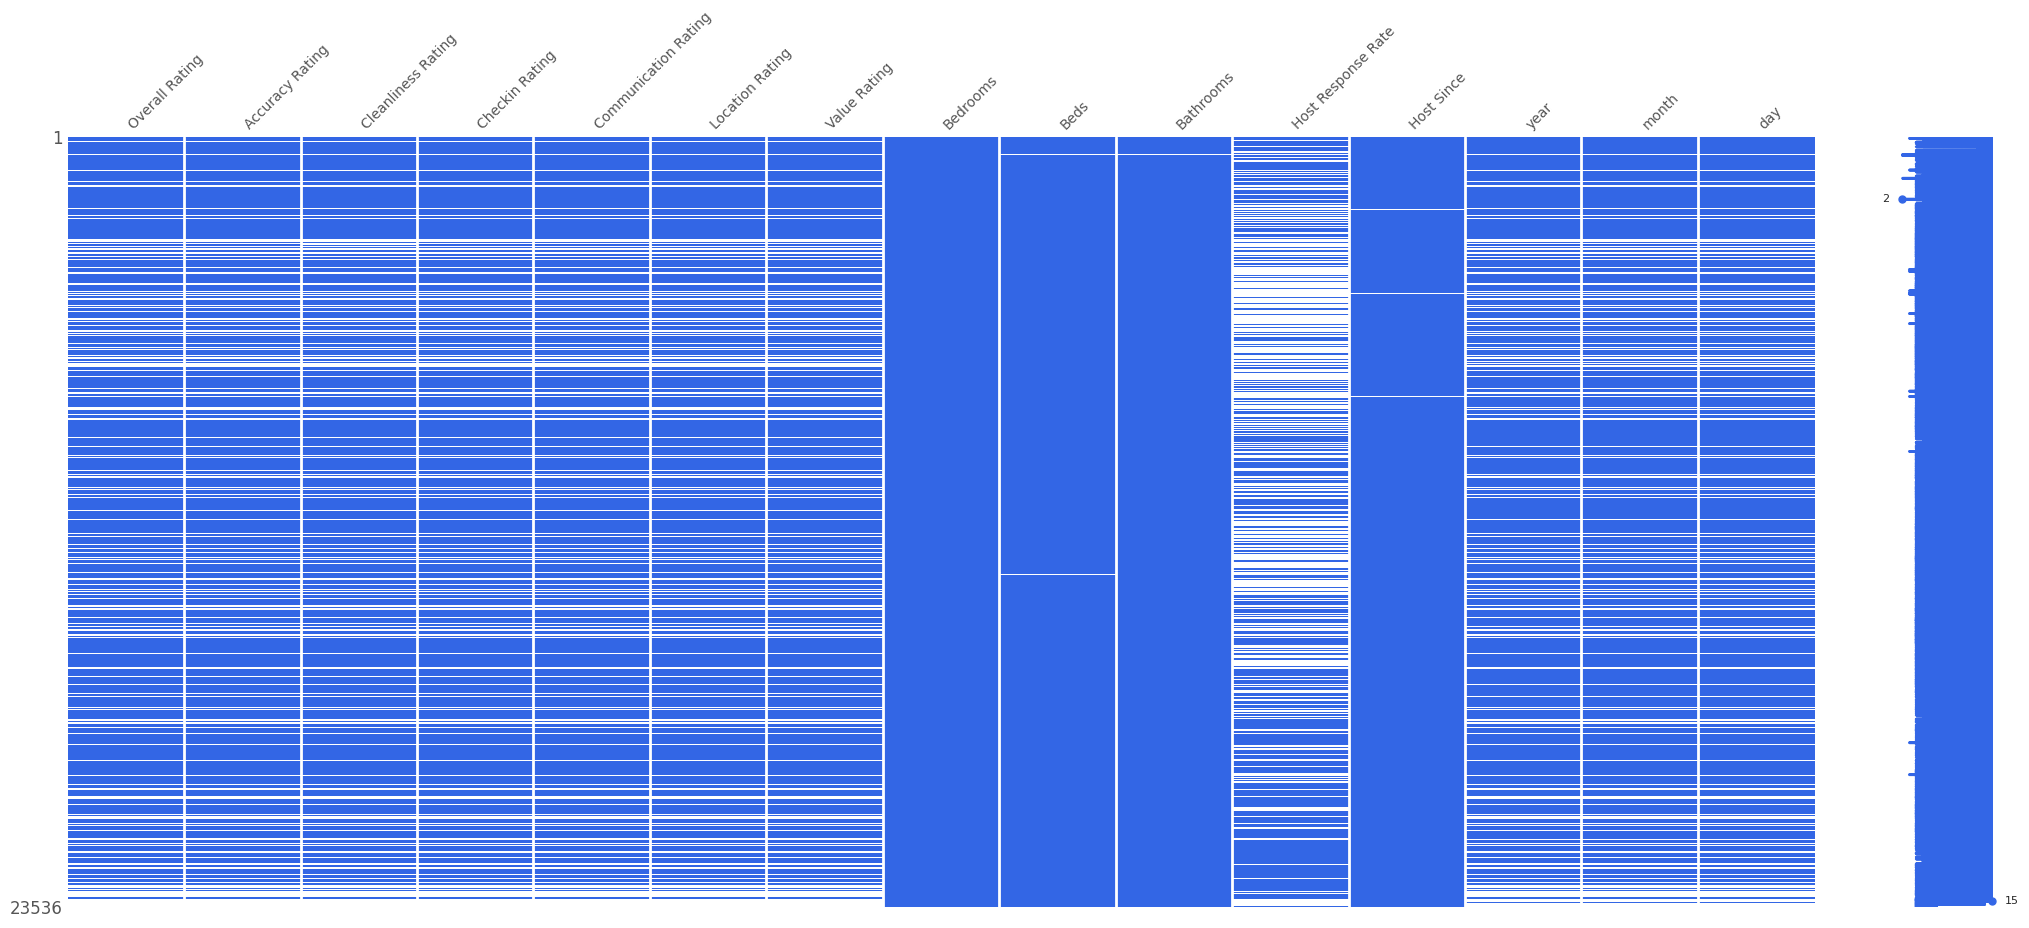

In [265]:
msno.matrix(df_nulls,color=(0.2, 0.4, 0.9),fontsize=10)

Dataframe containing missing value counts and their frequency:

In [266]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_per
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
     '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

Missing Values  % of Total Values
Host Response Rate             10490               44.6
Value Rating                    4668               19.8
Checkin Rating                  4666               19.8
Location Rating                 4665               19.8
Communication Rating            4650               19.8
Accuracy Rating                 4648               19.7
Cleanliness Rating              4644               19.7
Overall Rating                  4622               19.6
year                            4156               17.7
month                           4156               17.7
day                             4156               17.7
Beds                              35                0.1
Bathrooms                         29                0.1
Host Since                        21                0.1
Bedrooms                          20                0.1

Creating a dataframe with each of the missing values as 1, while non missing values are 0:

In [267]:
pd.set_option('display.max_columns', None)
df_missing_data = (df.isna()).astype('int64')
df_missing_data.describe()

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
count     23536.0    23536.000000     23536.000000        23536.000000   
mean          0.0        0.196380         0.197485            0.197315   
std           0.0        0.397268         0.398110            0.397980   
min           0.0        0.000000         0.000000            0.000000   
25%           0.0        0.000000         0.000000            0.000000   
50%           0.0        0.000000         0.000000            0.000000   
75%           0.0        0.000000         0.000000            0.000000   
max           0.0        1.000000         1.000000            1.000000   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
count    23536.000000          23536.000000     23536.000000  23536.000000   
mean         0.198249              0.197570         0.198207      0.198334   
std          0.398690              0.398174         0.398657      0.398754   
min          0.000000              0.000000         0.000000      0.000000   
25%          0.000000              0.000000         0.000000      0.000000   
50%          0.000000              0.000000         0.000000      0.000000   
75%          0.000000              0.000000         0.000000      0.000000   
max          1.000000              1.000000         1.000000      1.000000   

         Price  Reviews      Bedrooms          Beds     Bathrooms  \
count  23536.0  23536.0  23536.000000  23536.000000  23536.000000   
mean       0.0      0.0      0.000850      0.001487      0.001232   
std        0.0      0.0      0.029139      0.038535      0.035081   
min        0.0      0.0      0.000000      0.000000      0.000000   
25%        0.0      0.0      0.000000      0.000000      0.000000   
50%        0.0      0.0      0.000000      0.000000      0.000000   
75%        0.0      0.0      0.000000      0.000000      0.000000   
max        0.0      0.0      1.000000      1.000000      1.000000   

       Host Response Rate  Is Superhost  Latitude  Longitude  Accomodates  \
count        23536.000000       23536.0   23536.0    23536.0      23536.0   
mean             0.445700           0.0       0.0        0.0          0.0   
std              0.497053           0.0       0.0        0.0          0.0   
min              0.000000           0.0       0.0        0.0          0.0   
25%              0.000000           0.0       0.0        0.0          0.0   
50%              0.000000           0.0       0.0        0.0          0.0   
75%              1.000000           0.0       0.0        0.0          0.0   
max              1.000000           0.0       0.0        0.0          0.0   

       Guests Included  Min Nights  Instant Bookable    Host Since  \
count          23536.0     23536.0           23536.0  23536.000000   
mean               0.0         0.0               0.0      0.000892   
std                0.0         0.0               0.0      0.029858   
min                0.0         0.0               0.0      0.000000   
25%                0.0         0.0               0.0      0.000000   
50%                0.0         0.0               0.0      0.000000   
75%                0.0         0.0               0.0      0.000000   
max                0.0         0.0               0.0      1.000000   

       Is Exact Location          year         month           day  \
count            23536.0  23536.000000  23536.000000  23536.000000   
mean                 0.0      0.176581      0.176581      0.176581   
std                  0.0      0.381321      0.381321      0.381321   
min                  0.0      0.000000      0.000000      0.000000   
25%                  0.0      0.000000      0.000000      0.000000   
50%                  0.0      0.000000      0.000000      0.000000   
75%                  0.0      0.000000      0.000000      0.000000   
max                  0.0      1.000000      1.000000      1.000000   

       Host Response Time Encoded  Host Response Rate Clean

### Data Cleansing

<Axes: >

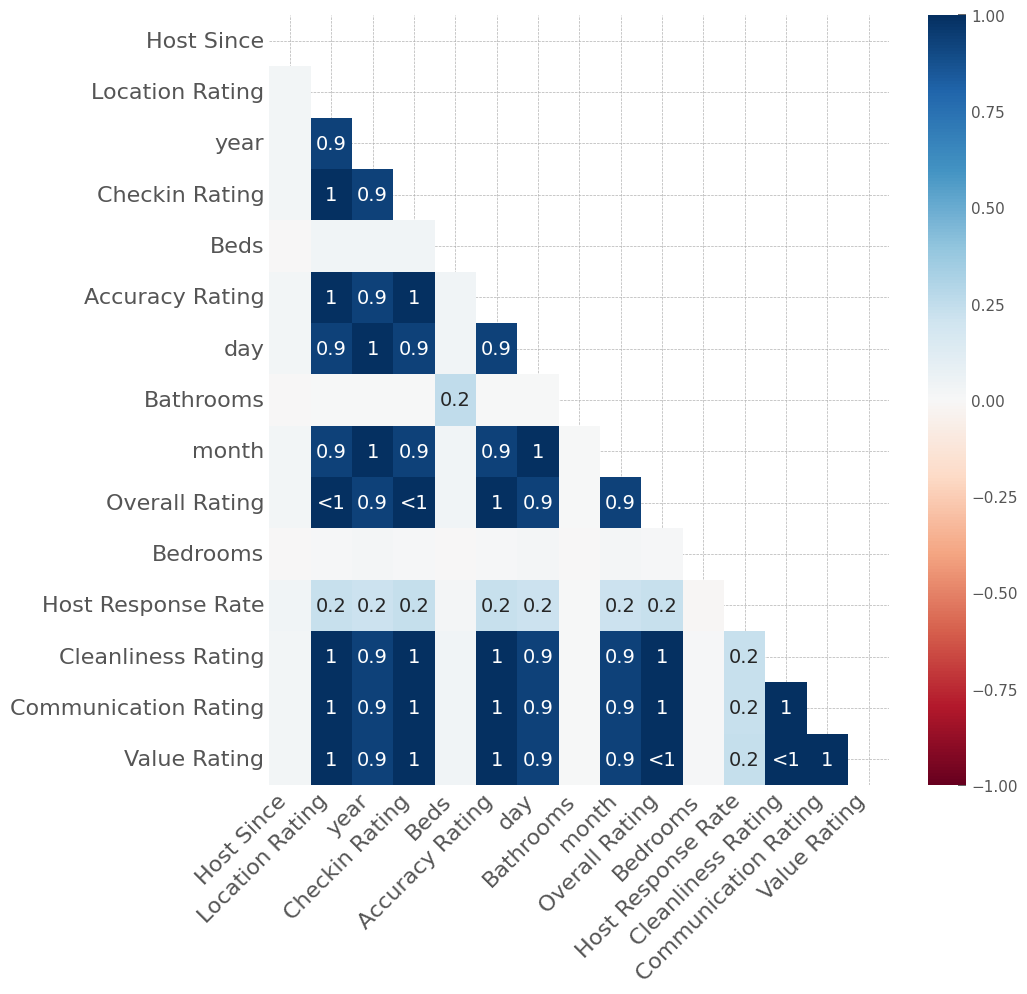

In [268]:
msno.heatmap(df_num_non_dummy,figsize=(10,10))

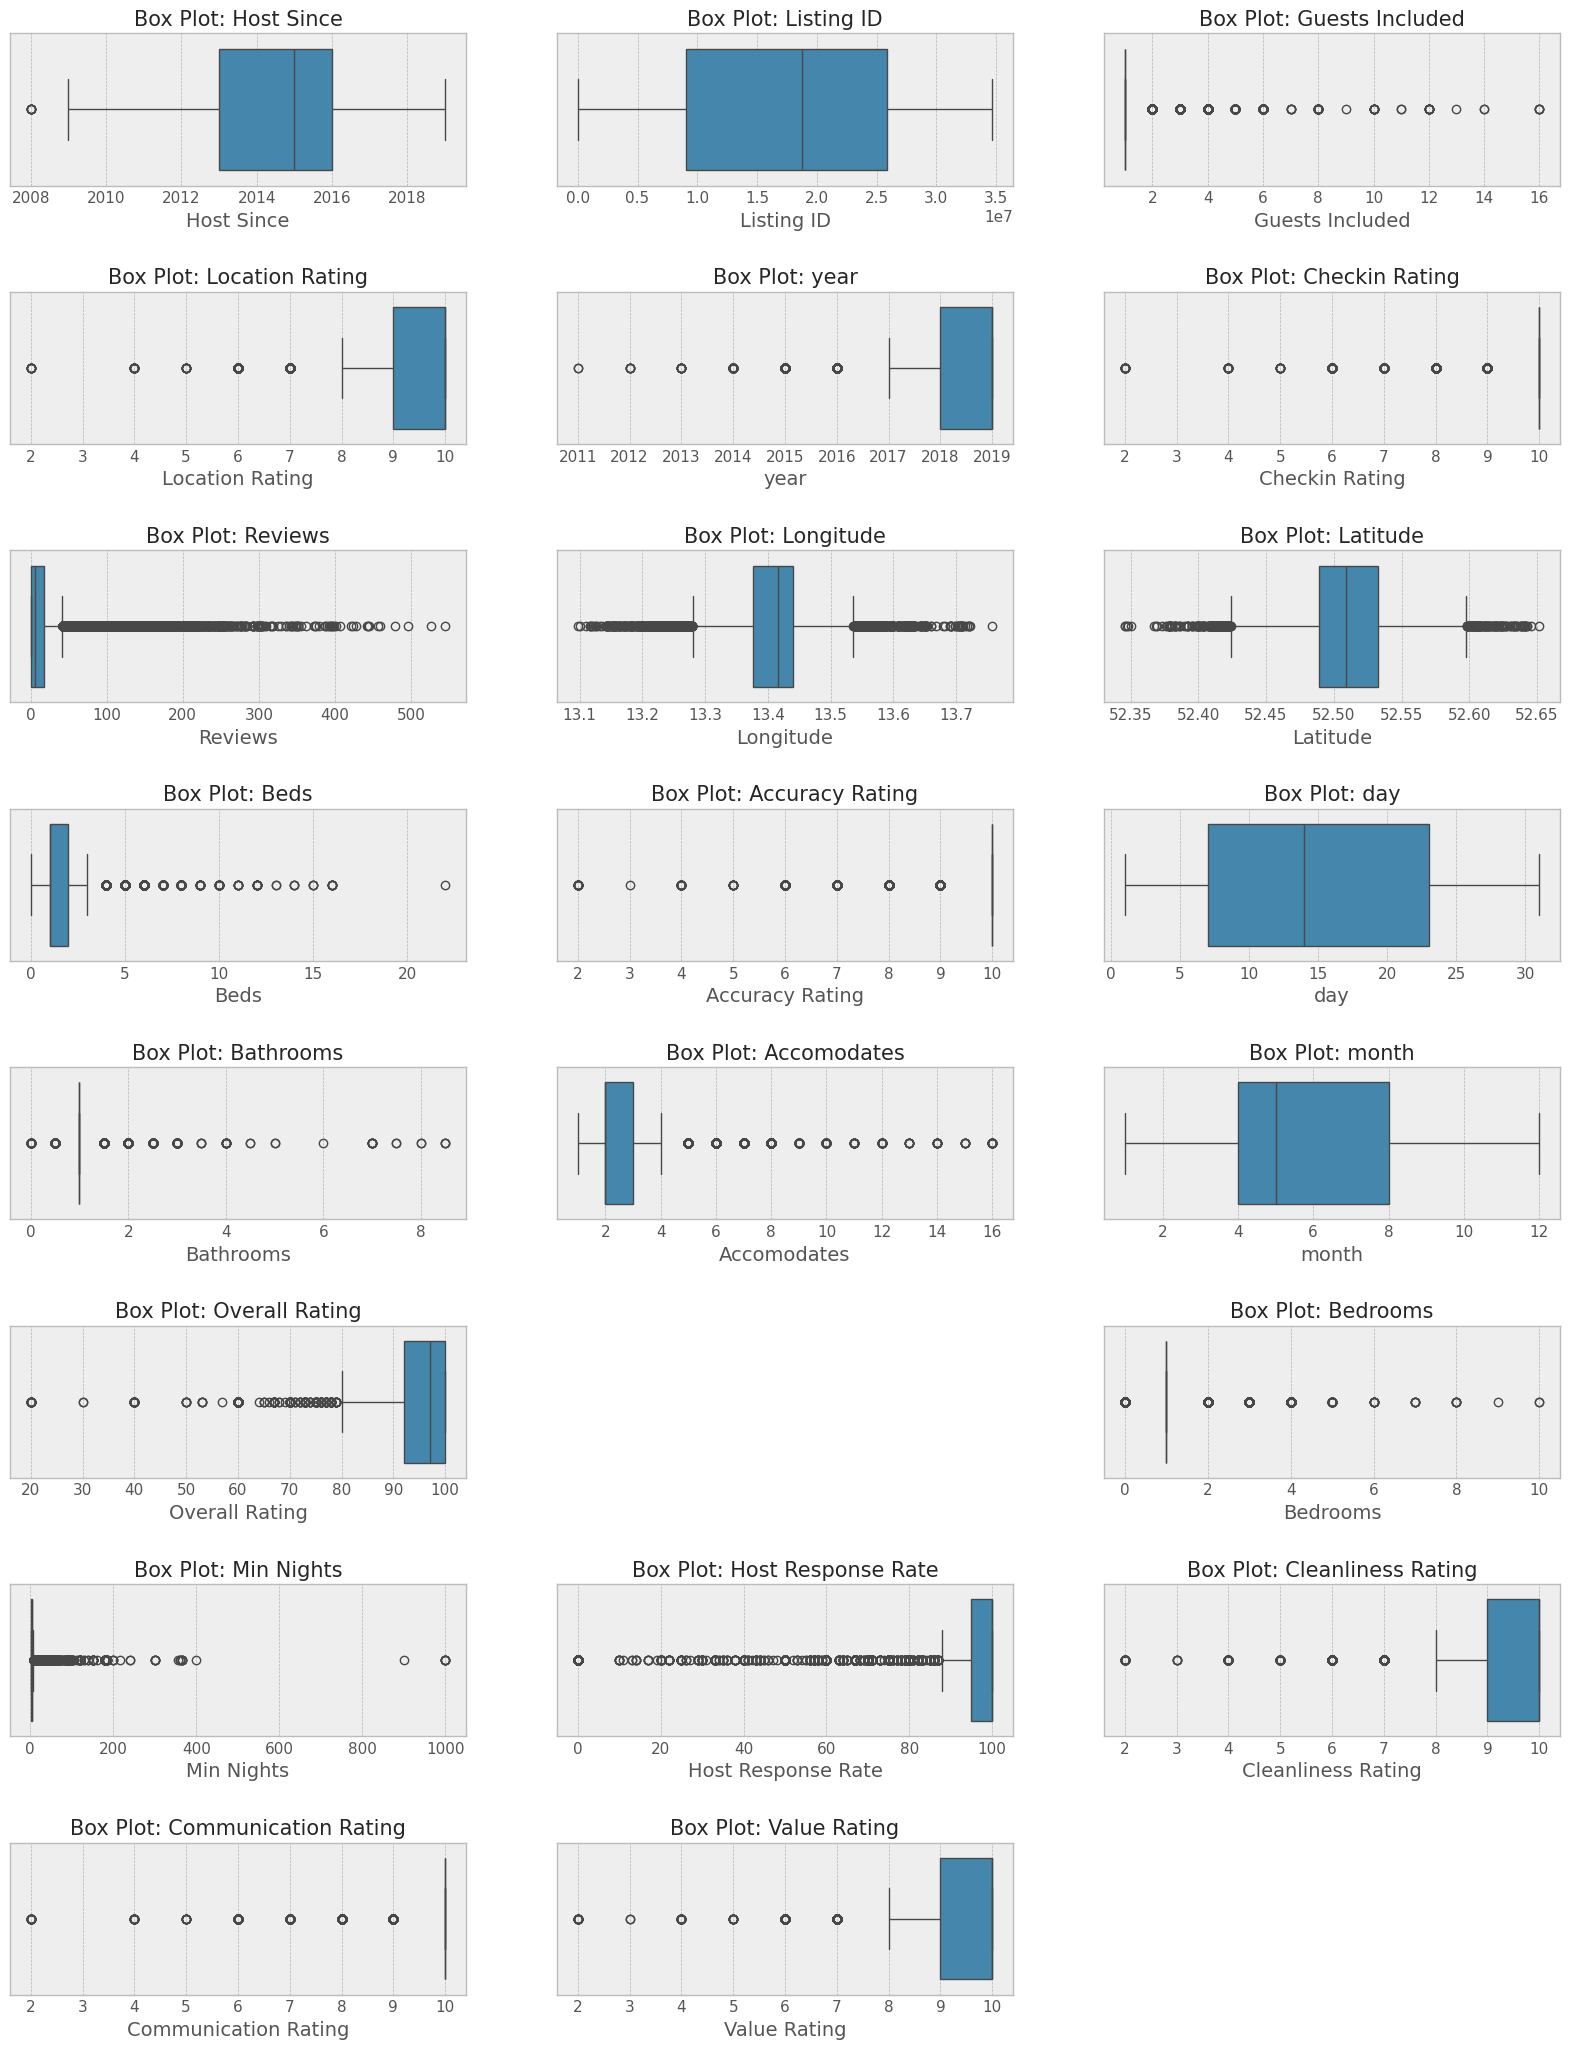

In [269]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'Price':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df_num_non_dummy)

### outliers_df
The data is skewed and not normaly distributed, we'll use the IQR method to identify outliers to set up a boundary before Q1 and after Q3. Any values that fall outside of this boundary are considered outliers:

In [270]:
def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in df:  # Ensure processing numeric columns only
      if (col != "Price"):
        temp = pd.DataFrame(df[col])
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        # Filter rows that are outliers in either direction
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]

# Assume con_df is your DataFrame
# Call the function and sort results
outliers_df = outliers_df(df_num_non_dummy).sort_values('Percent', ascending=False)
outliers_df

Outlier count    Percent
Bedrooms                     5810.0  24.685588
Guests Included              5447.0  23.143270
Accuracy Rating              4367.0  18.554555
Checkin Rating               3700.0  15.720598
Communication Rating         3423.0  14.543678
Reviews                      2983.0  12.674201
Bathrooms                    2813.0  11.951903
Min Nights                   2520.0  10.707002
year                         2473.0  10.507308
Host Response Rate           2188.0   9.296397
Accomodates                  2116.0   8.990483
Beds                         1611.0   6.844833
Cleanliness Rating            941.0   3.998131
Longitude                     775.0   3.292828
Overall Rating                465.0   1.975697
Value Rating                  427.0   1.814242
Latitude                      331.0   1.406356
Location Rating               303.0   1.287390
Host Since                      7.0   0.029742

### new_outliers_df
Labeling every outlier with 'Outlier' in order to seperate the outliers from nulls (temporarily, and then to 0/1):

In [271]:
def outliers(df):
    label_out_df = df.copy()
    for col in label_out_df:
      if (col != "Price"):
        if col in outliers_df.index:
            Q1 = label_out_df[col].quantile(0.25)
            Q3 = label_out_df[col].quantile(0.75)
            lower_limit = Q1 - 1.5 * (Q3-Q1)
            upper_limit = Q3 + 1.5 * (Q3-Q1)
            label_out_df[col] = np.where(label_out_df[col] > upper_limit,'Outlier',np.where(label_out_df[col] < lower_limit,'Outlier',label_out_df[col]))
    return label_out_df
new_df_outliers = outliers(df)
new_df_outliers.head(10)

Listing ID Overall Rating Accuracy Rating Cleanliness Rating  \
0        2695          100.0            10.0               10.0   
1        3176           92.0         Outlier                9.0   
2        7071           96.0            10.0               10.0   
3        9991          100.0            10.0               10.0   
4       14325           93.0            10.0               10.0   
5       16401            nan             nan                nan   
6       16644           94.0            10.0               10.0   
7       17904           96.0            10.0               10.0   
8       20858           88.0         Outlier                9.0   
9       21869           95.0         Outlier               10.0   

  Checkin Rating Communication Rating Location Rating Value Rating  Price  \
0           10.0                 10.0             9.0         10.0   17.0   
1        Outlier              Outlier            10.0          9.0   90.0   
2           10.0                 10.0            10.0         10.0   33.0   
3           10.0                 10.0            10.0         10.0  180.0   
4        Outlier                 10.0             9.0          9.0   70.0   
5            nan                  nan             nan          nan  120.0   
6           10.0                 10.0             9.0          9.0   90.0   
7           10.0                 10.0            10.0          9.0   49.0   
8        Outlier              Outlier            10.0          9.0  129.0   
9           10.0              Outlier             9.0          9.0   70.0   

   Reviews Bedrooms     Beds Bathrooms Host Response Rate  Is Superhost  \
0      7.0      1.0      1.0       1.0            Outlier         False   
1  Outlier      1.0      2.0       1.0            Outlier         False   
2  Outlier      1.0      2.0       1.0              100.0          True   
3      6.0  Outlier  Outlier   Outlier              100.0         False   
4     23.0  Outlier      1.0       1.0              100.0         False   
5      0.0      1.0      2.0       1.0                nan         False   
6  Outlier      1.0      3.0       1.0                nan         False   
7  Outlier      nan      1.0       1.0              100.0         False   
8  Outlier  Outlier      2.0       1.0              100.0         False   
9  Outlier      1.0      2.0       1.0                nan         False   

   Latitude Longitude Accomodates Guests Included Min Nights  \
0  52.54851  13.40455           2               1          2   
1    52.535  13.41758           4         Outlier    Outlier   
2  52.54316  13.41509           2               1          2   
3  52.53303  13.41605     Outlier         Outlier          6   
4  52.54785  13.40556           1               1    Outlier   
5  52.51051  13.45785           2               1    Outlier   
6  52.50479   13.4351     Outlier         Outlier    Outlier   
7  52.49548  13.42182           2               1          5   
8  52.53695  13.40762           4         Outlier          3   
9  52.50273  13.43462           4         Outlier    Outlier   

   Instant Bookable Host Since  Is Exact Location     year  month   day  \
0             False    Outlier               True   2019.0    4.0  21.0   
1             False    Outlier               True   2018.0   10.0  29.0   
2             False     2009.0               True   2019.0    5.0   8.0   
3             False     2009.0              False   2018.0    7.0  23.0   
4             False     2009.0               True   2018.0   11.0   1.0   
5             False     2009.0               True      nan    NaN   NaN   
6             False     2009.0               True   2017.0   12.0  14.0   
7             False     2010.0              False   2019.0    4.0  17.0   
8             False     2010.0               True   2019.0    4.0  15.0   
9             False     2009.0               True  Outlier    6.0   5.0   

   Host Response Time Encoded  Host Response Rate Cleansed E

In [272]:
new_df_outliers['Host Since']

0        Outlier
1        Outlier
2         2009.0
3         2009.0
4         2009.0
          ...   
23531     2018.0
23532     2019.0
23533     2014.0
23534     2019.0
23535     2018.0
Name: Host Since, Length: 23536, dtype: object

Creating a dataframe with outliers as 1 and non-outliers as 0:

In [273]:
df_outliers = new_df_outliers.isin(['Outlier'])
df_outliers = df_outliers.astype('int')
df_outliers

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0               0               0                0                   0   
1               0               0                1                   0   
2               0               0                0                   0   
3               0               0                0                   0   
4               0               0                0                   0   
...           ...             ...              ...                 ...   
23531           0               0                0                   0   
23532           0               0                0                   0   
23533           0               0                0                   0   
23534           0               0                0                   0   
23535           0               0                0                   0   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
0                   0                     0                0             0   
1                   1                     1                0             0   
2                   0                     0                0             0   
3                   0                     0                0             0   
4                   1                     0                0             0   
...               ...                   ...              ...           ...   
23531               0                     0                0             0   
23532               0                     0                0             0   
23533               0                     0                0             0   
23534               0                     0                0             0   
23535               0                     0                0             0   

       Price  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0          0        0         0     0          0                   1   
1          0        1         0     0          0                   1   
2          0        1         0     0          0                   0   
3          0        0         1     1          1                   0   
4          0        0         1     0          0                   0   
...      ...      ...       ...   ...        ...                 ...   
23531      0        0         0     0          0                   1   
23532      0        0         1     0          0                   0   
23533      0        0         0     0          1                   0   
23534      0        0         1     1          0                   0   
23535      0        0         1     0          0                   0   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0                 0         0          0            0                0   
1                 0         0          0            0                1   
2                 0         0          0            0                0   
3                 0         0          0            1                1   
4                 0         0          0            0                0   
...             ...       ...        ...          ...              ...   
23531             0         1          1            0                0   
23532             0         1          0            0                1   
23533             0         0          0            0                0   
23534             0         0          1            1                0   
23535             0         0          0            0                0   

       Min Nights  Instant Bookable  Host Since  Is Exact Location  year  \
0               0                 0           1                  0     0   
1               1                 0           1                  0     0   
2               0                 0           0                  0     0   
3               0                 0           0                  0     0   
4               1                 0           0

Now that we have a dataframe saving all the outliers we'll convert all the outliers to nulls, just so I can see differences in distribution with and without outliers and then decide which of the outliers to remove or not:

In [274]:
def capping(df):
    temp = df.copy()
    for col in temp:
        if col in outliers_df.index and col != "Price":
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            lower_limit = Q1 - 1.5 * (Q3-Q1)
            upper_limit = Q3 + 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
temp = capping(df)
temp

Listing ID  Overall Rating  Accuracy Rating  Cleanliness Rating  \
0            2695           100.0             10.0                10.0   
1            3176            92.0              NaN                 9.0   
2            7071            96.0             10.0                10.0   
3            9991           100.0             10.0                10.0   
4           14325            93.0             10.0                10.0   
...           ...             ...              ...                 ...   
23531    34678365             NaN              NaN                 NaN   
23532    34681094             NaN              NaN                 NaN   
23533    34681403             NaN              NaN                 NaN   
23534    34681413             NaN              NaN                 NaN   
23535    34682315             NaN              NaN                 NaN   

       Checkin Rating  Communication Rating  Location Rating  Value Rating  \
0                10.0                  10.0              9.0          10.0   
1                 NaN                   NaN             10.0           9.0   
2                10.0                  10.0             10.0          10.0   
3                10.0                  10.0             10.0          10.0   
4                 NaN                  10.0              9.0           9.0   
...               ...                   ...              ...           ...   
23531             NaN                   NaN              NaN           NaN   
23532             NaN                   NaN              NaN           NaN   
23533             NaN                   NaN              NaN           NaN   
23534             NaN                   NaN              NaN           NaN   
23535             NaN                   NaN              NaN           NaN   

       Price  Reviews  Bedrooms  Beds  Bathrooms  Host Response Rate  \
0       17.0      7.0       1.0   1.0        1.0                 NaN   
1       90.0      NaN       1.0   2.0        1.0                 NaN   
2       33.0      NaN       1.0   2.0        1.0               100.0   
3      180.0      6.0       NaN   NaN        NaN               100.0   
4       70.0     23.0       NaN   1.0        1.0               100.0   
...      ...      ...       ...   ...        ...                 ...   
23531   48.0      0.0       1.0   2.0        1.0                 NaN   
23532   30.0      0.0       NaN   2.0        1.0                 NaN   
23533   17.0      0.0       1.0   1.0        NaN                 NaN   
23534   52.0      0.0       NaN   NaN        1.0                 NaN   
23535   65.0      0.0       NaN   2.0        1.0                 NaN   

       Is Superhost  Latitude  Longitude  Accomodates  Guests Included  \
0             False  52.54851   13.40455          2.0              1.0   
1             False  52.53500   13.41758          4.0              NaN   
2              True  52.54316   13.41509          2.0              1.0   
3             False  52.53303   13.41605          NaN              NaN   
4             False  52.54785   13.40556          1.0              1.0   
...             ...       ...        ...          ...              ...   
23531         False       NaN        NaN          3.0              1.0   
23532         False       NaN   13.49340          2.0              NaN   
23533         False  52.45402   13.43864          1.0              1.0   
23534         False  52.47342        NaN          NaN              1.0   
23535         False  52.54929   13.46067          3.0              1.0   

       Min Nights  Instant Bookable  Host Since  Is Exact Location    year  \
0             2.0             False         NaN               True  2019.0   
1             NaN             False         NaN               True  2018.0   
2             2.0             False      2009.0               True  2019.0   
3             6.0             False      2009.0              False  2018.0   
4             NaN             False  

Host Since


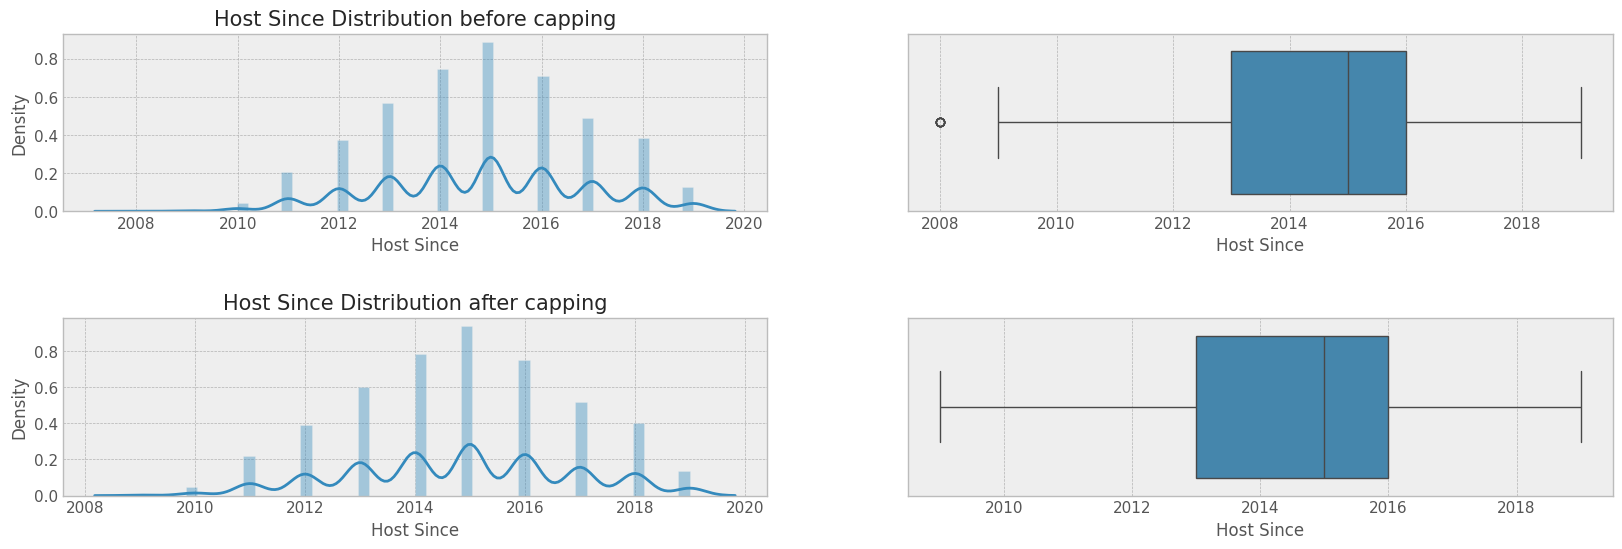

Guests Included


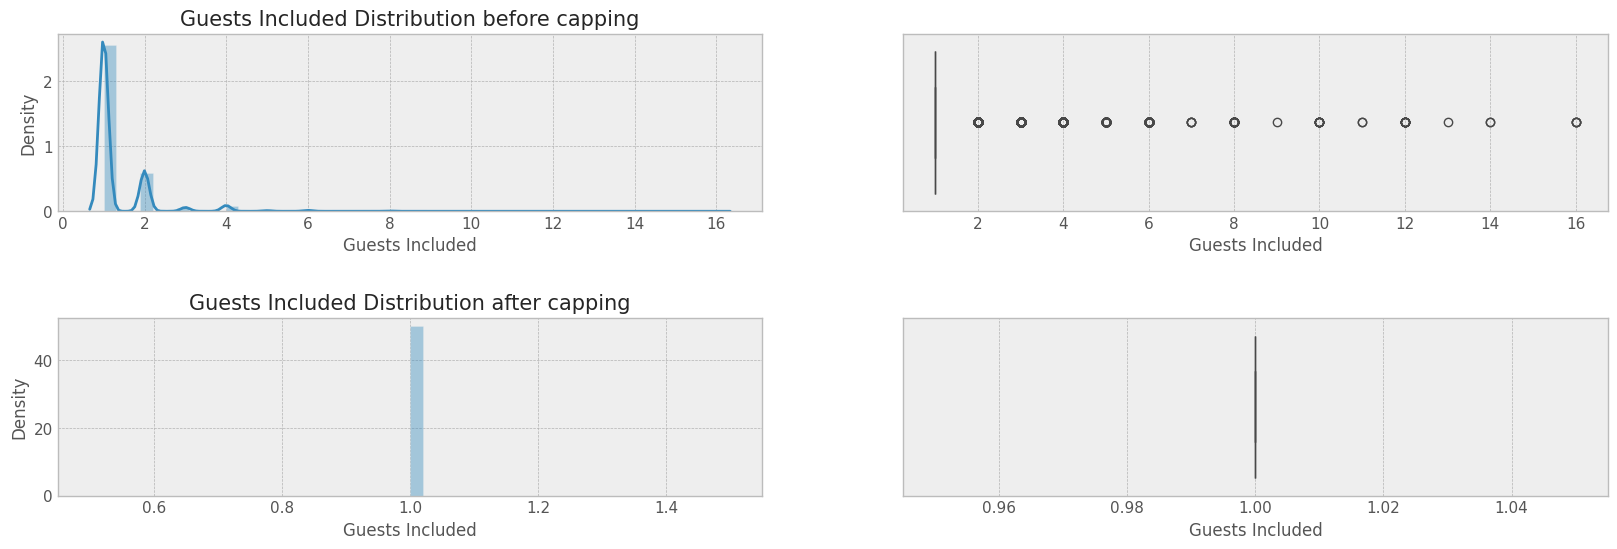

Location Rating


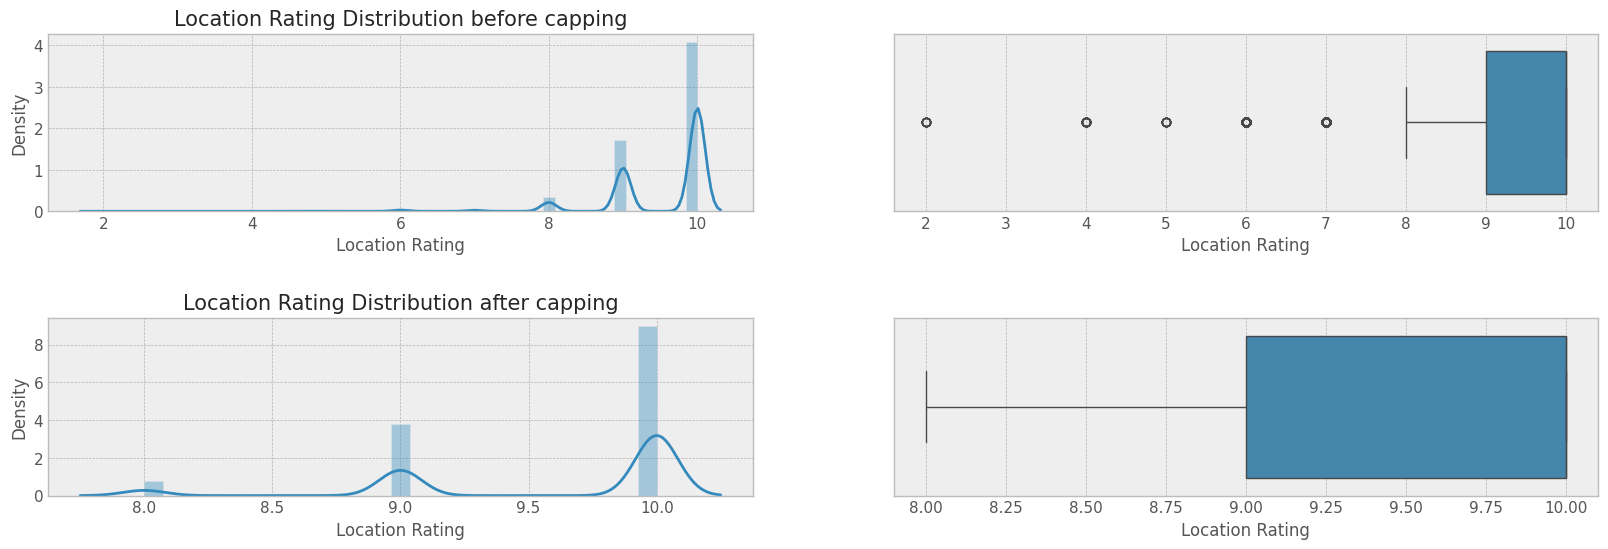

year


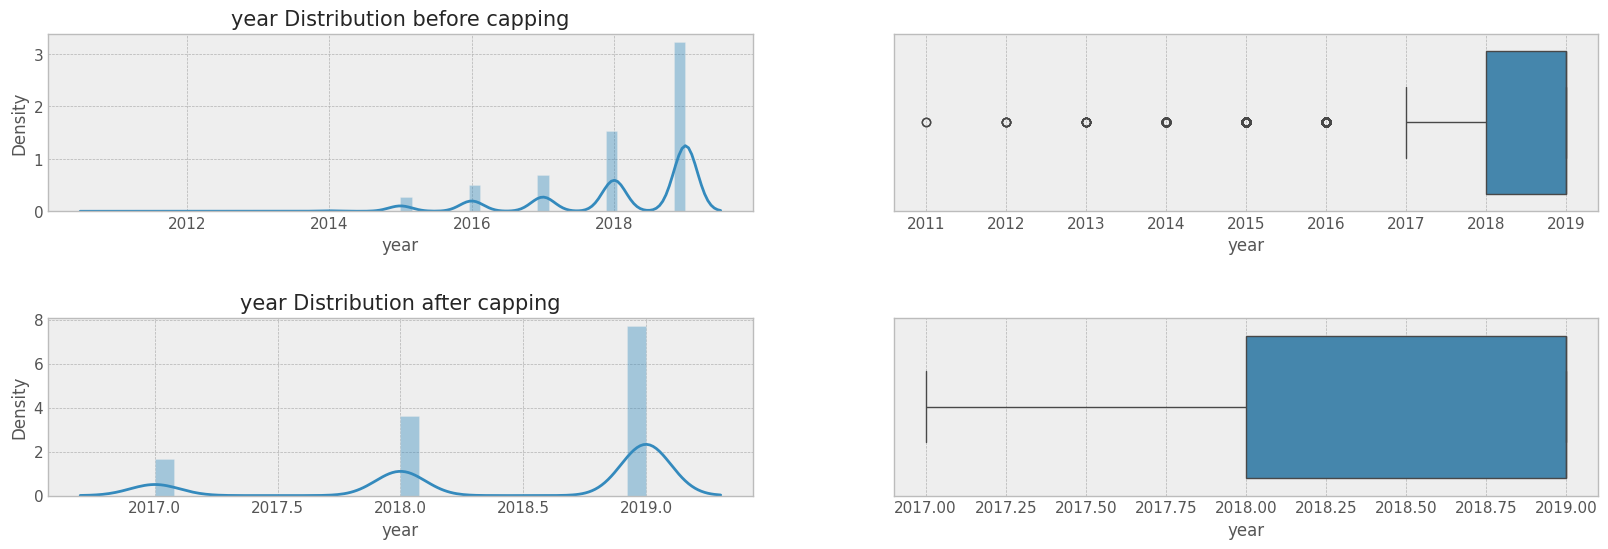

Checkin Rating


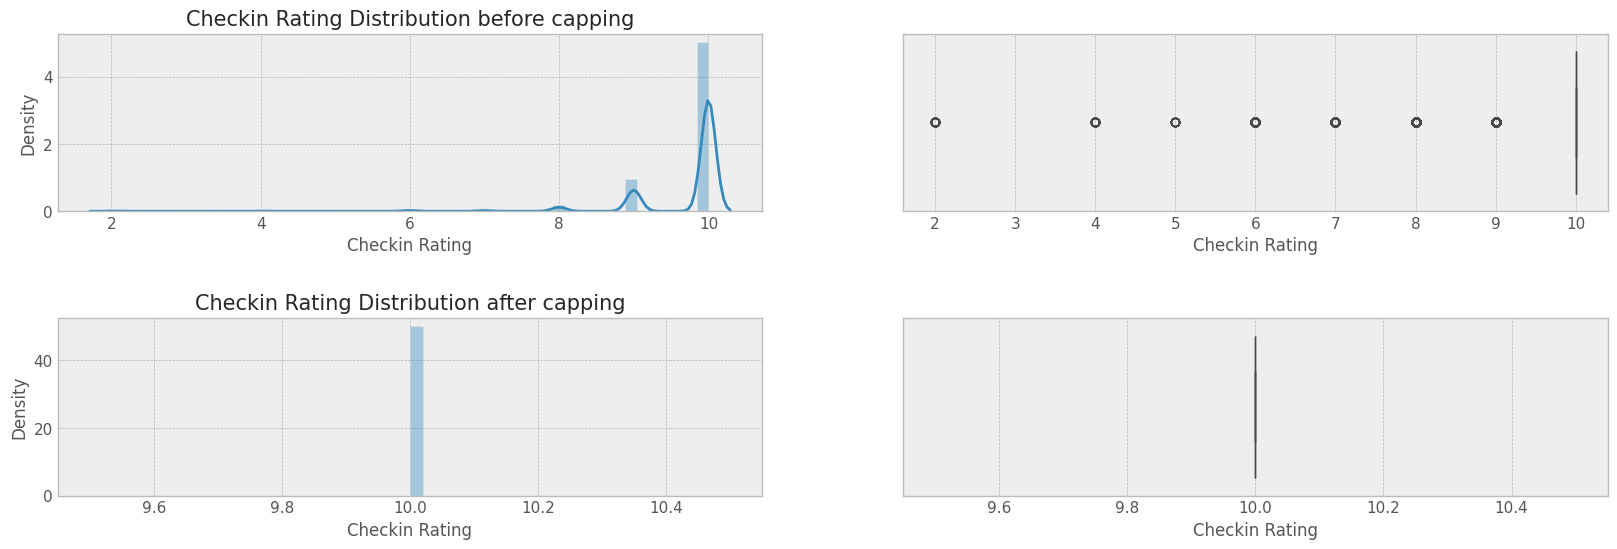

Reviews


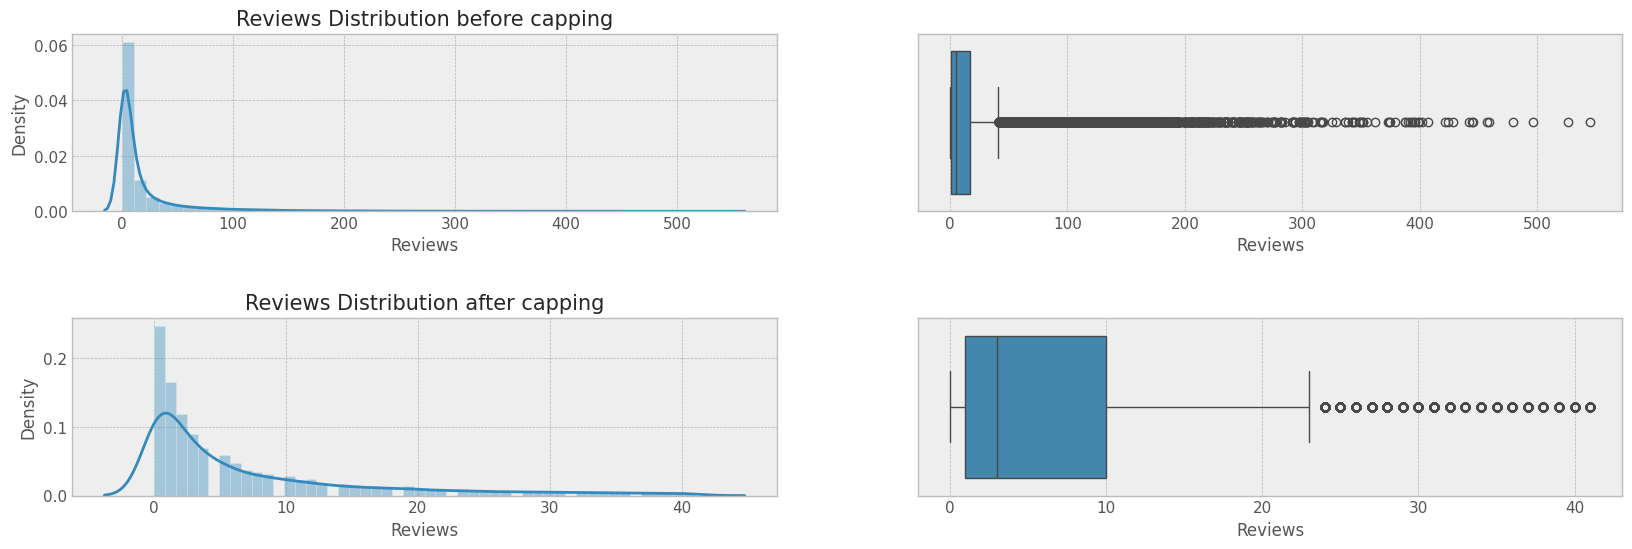

Longitude


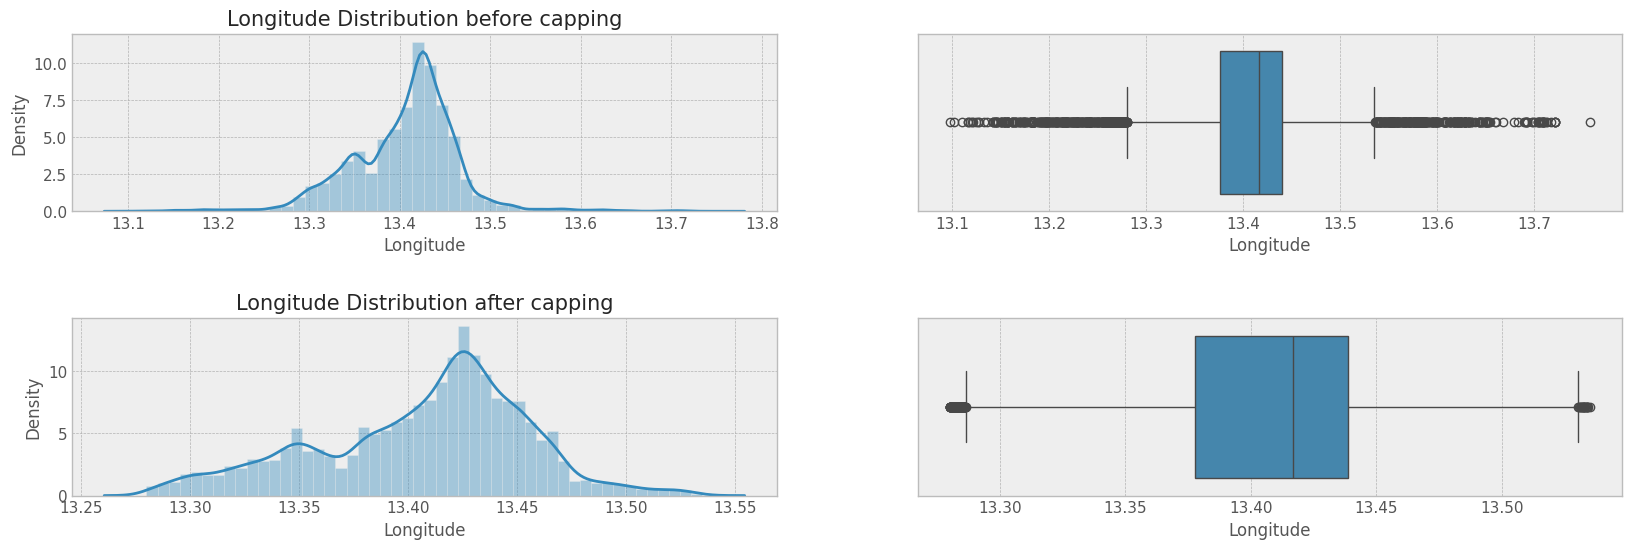

Latitude


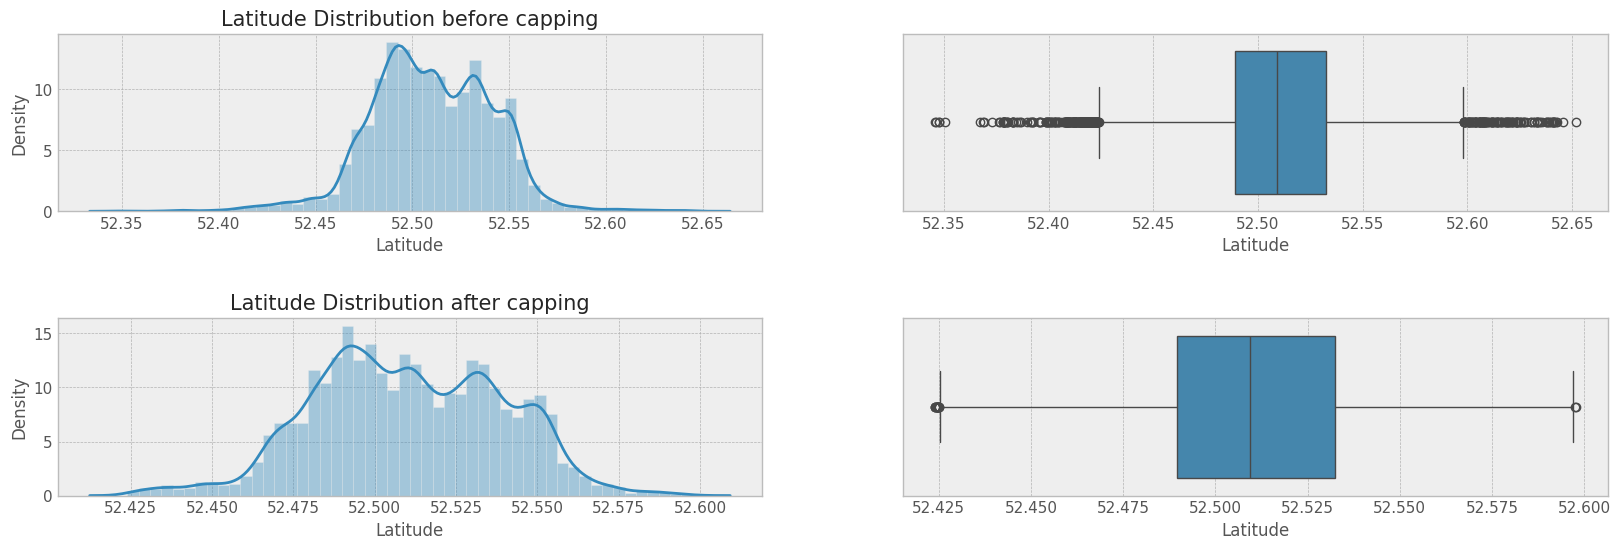

Beds


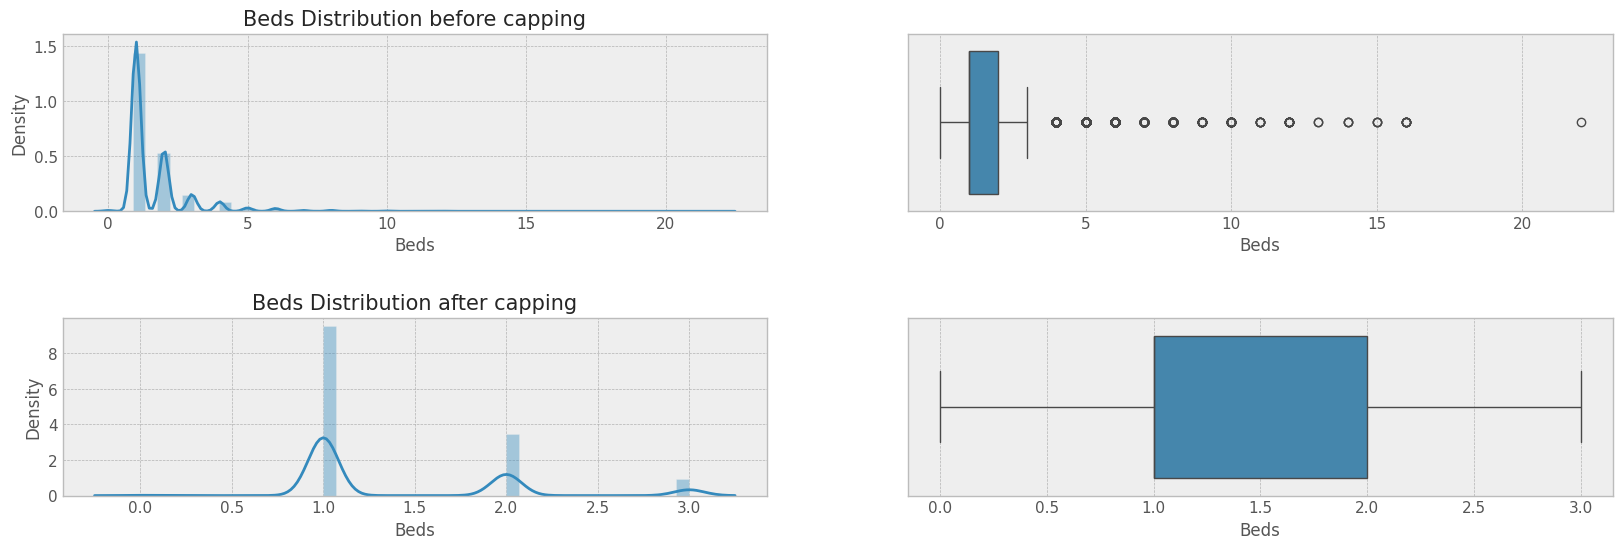

Accuracy Rating


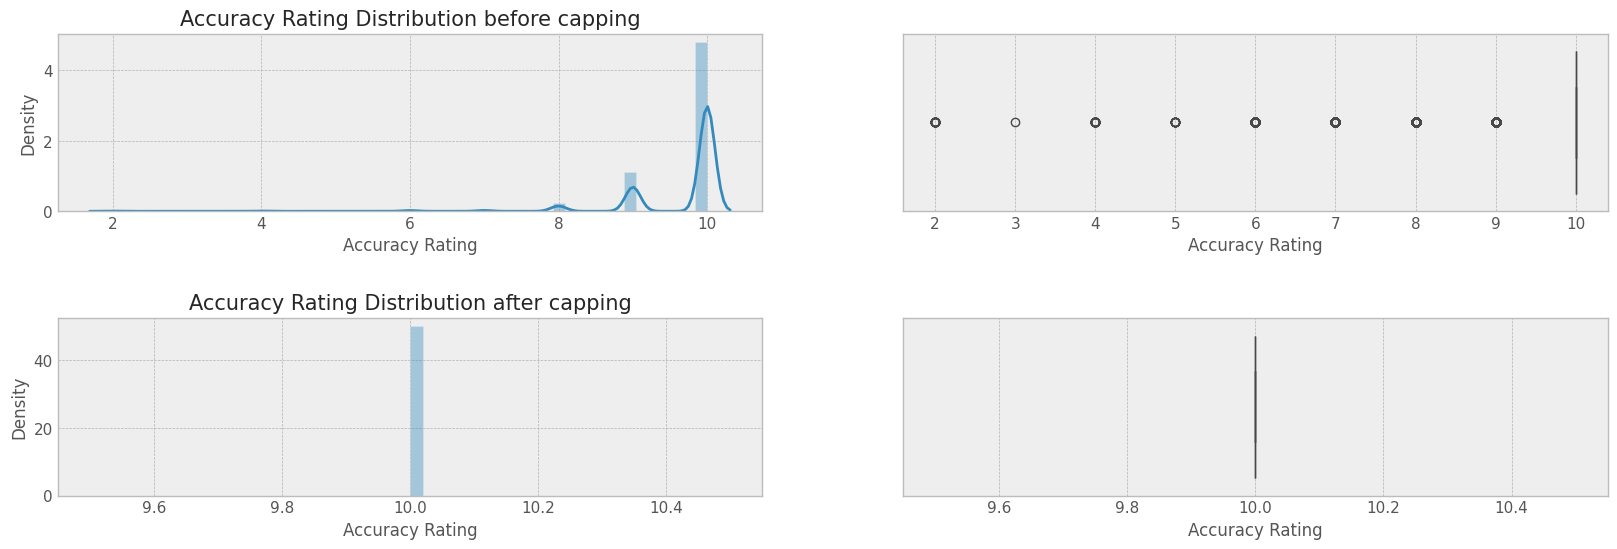

Bathrooms


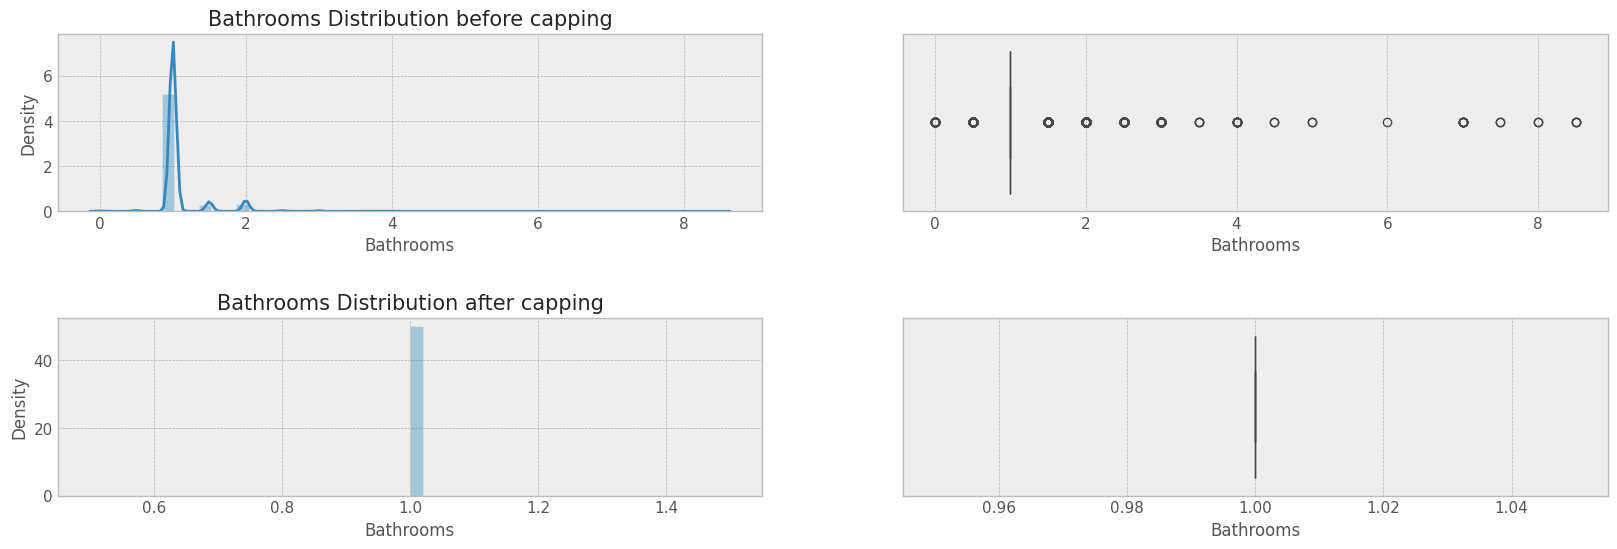

Accomodates


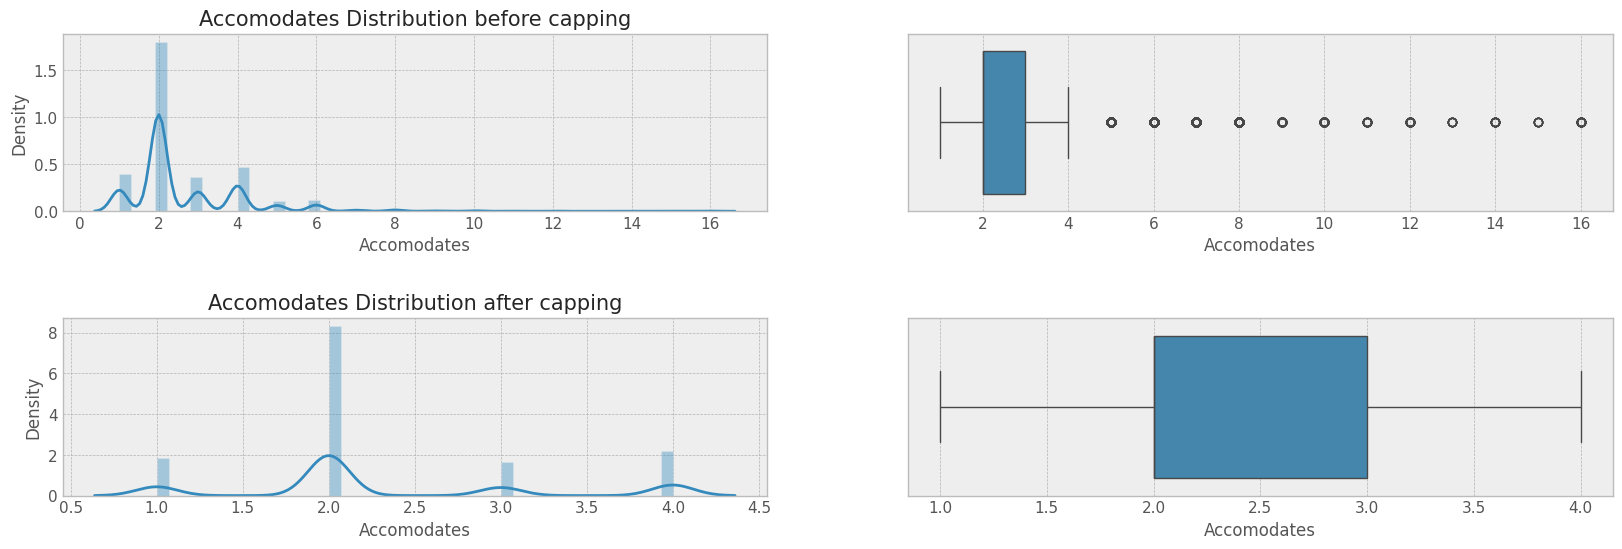

Overall Rating


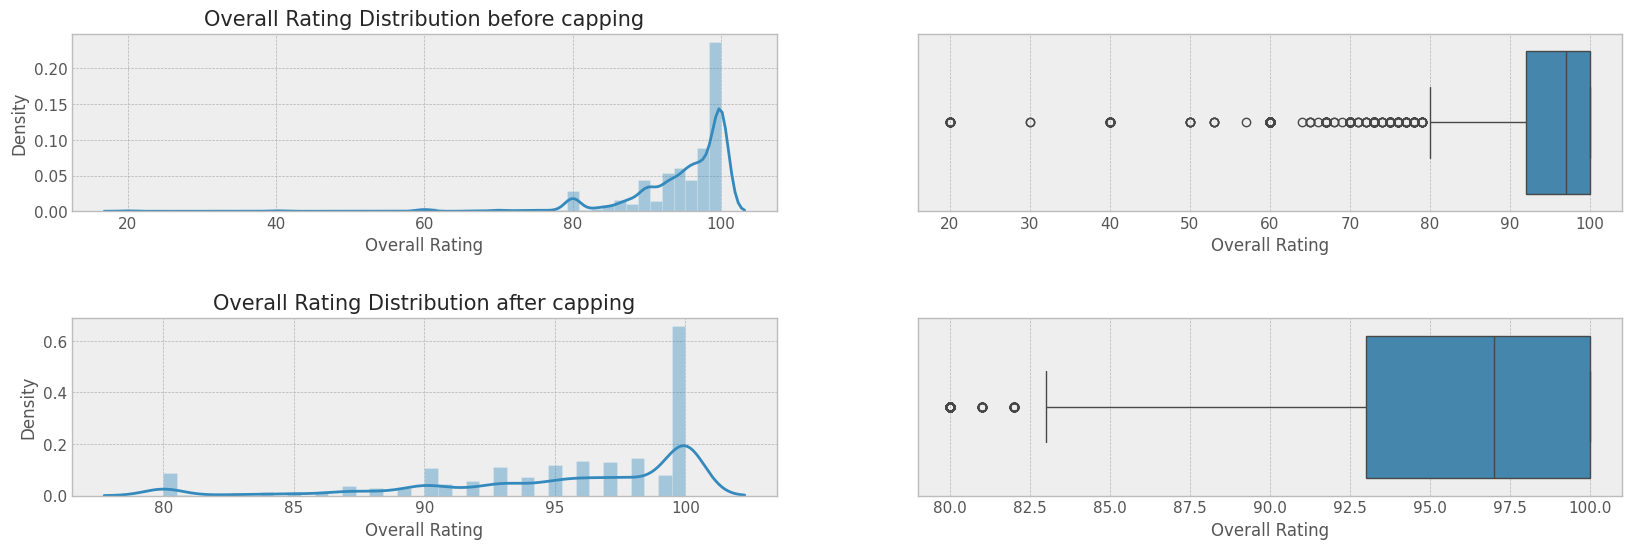

Bedrooms


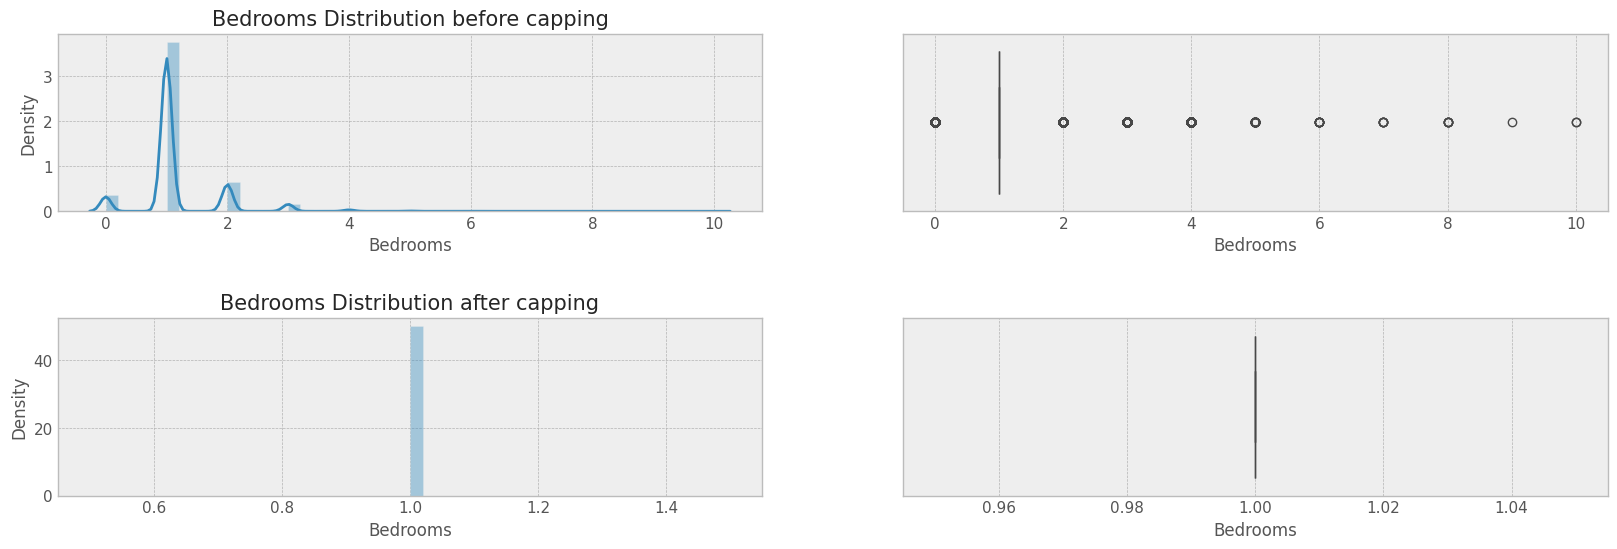

Min Nights


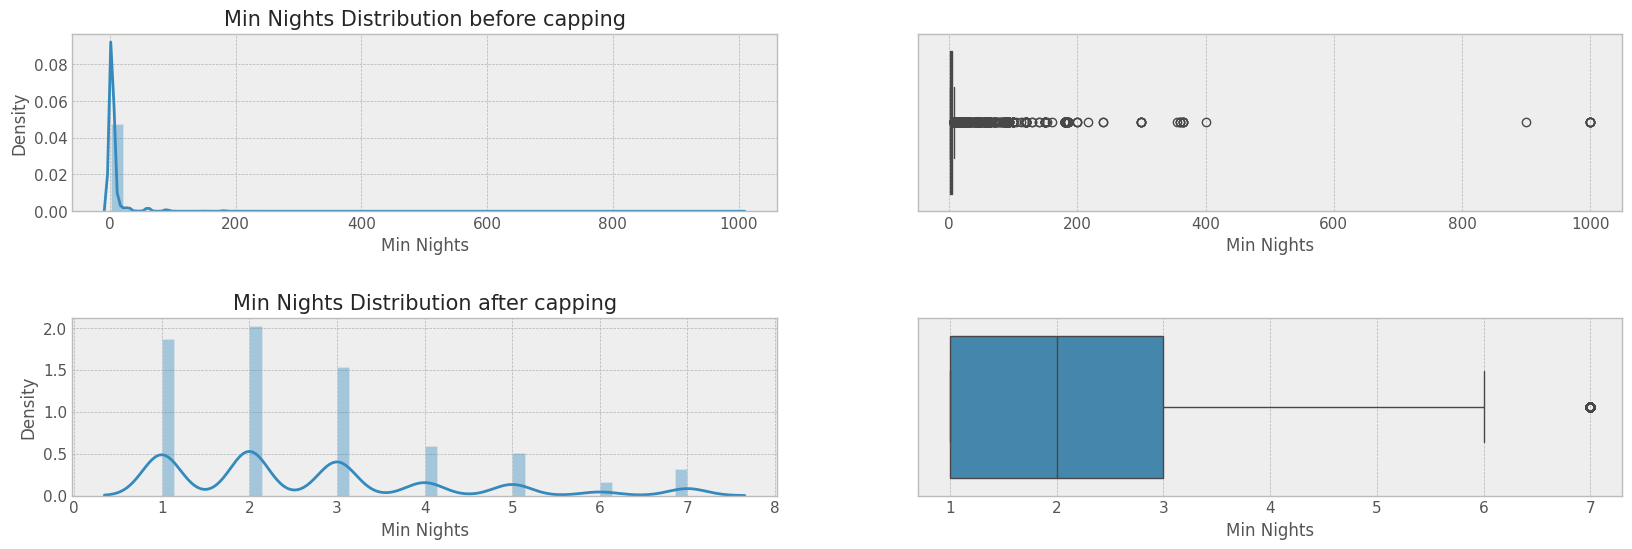

Host Response Rate


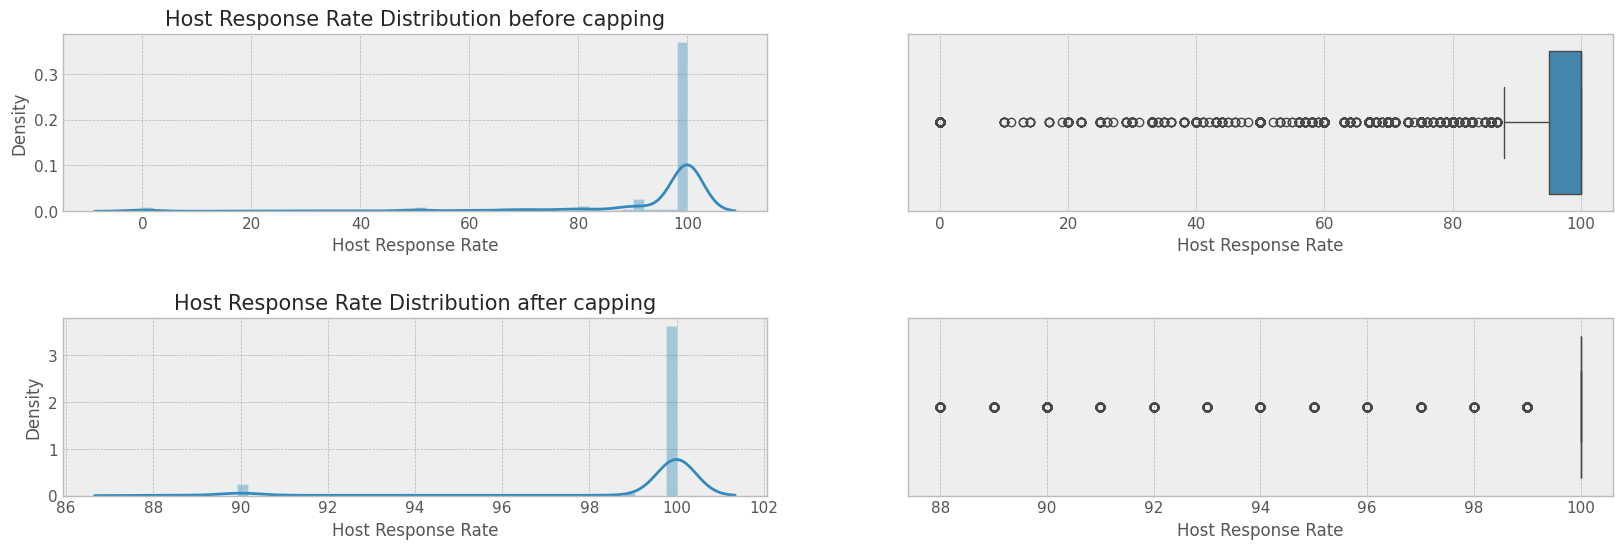

Cleanliness Rating


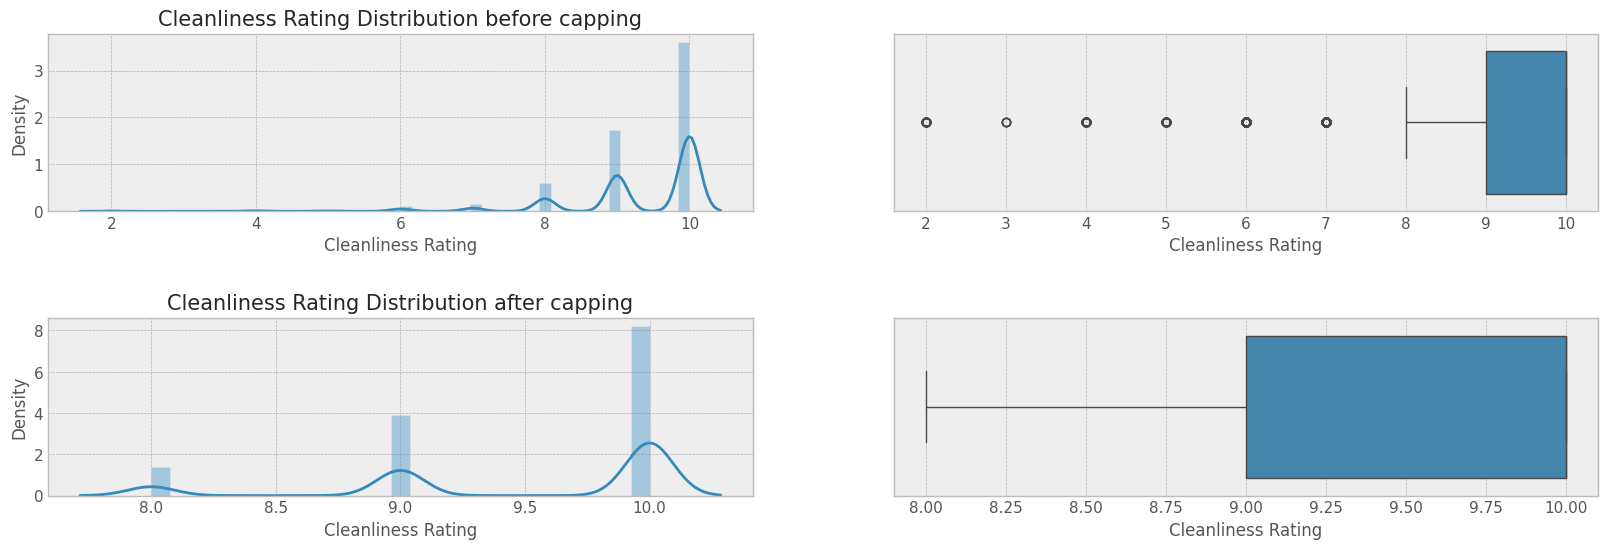

Communication Rating


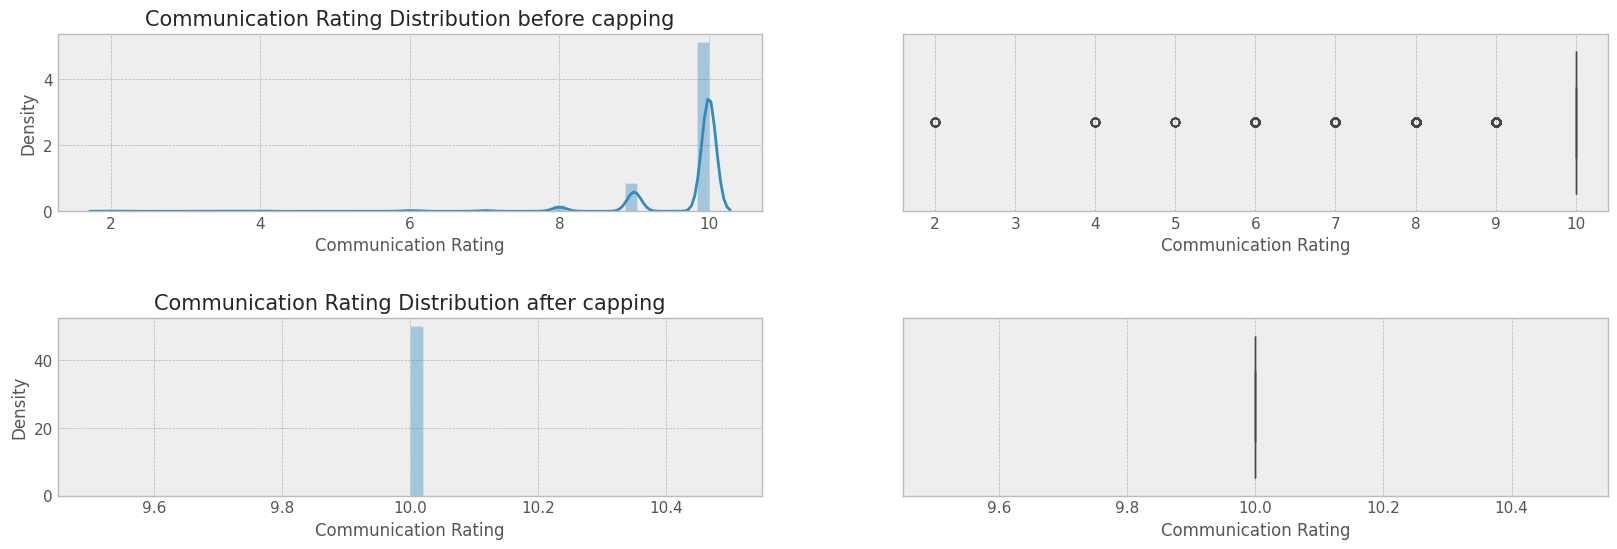

Value Rating


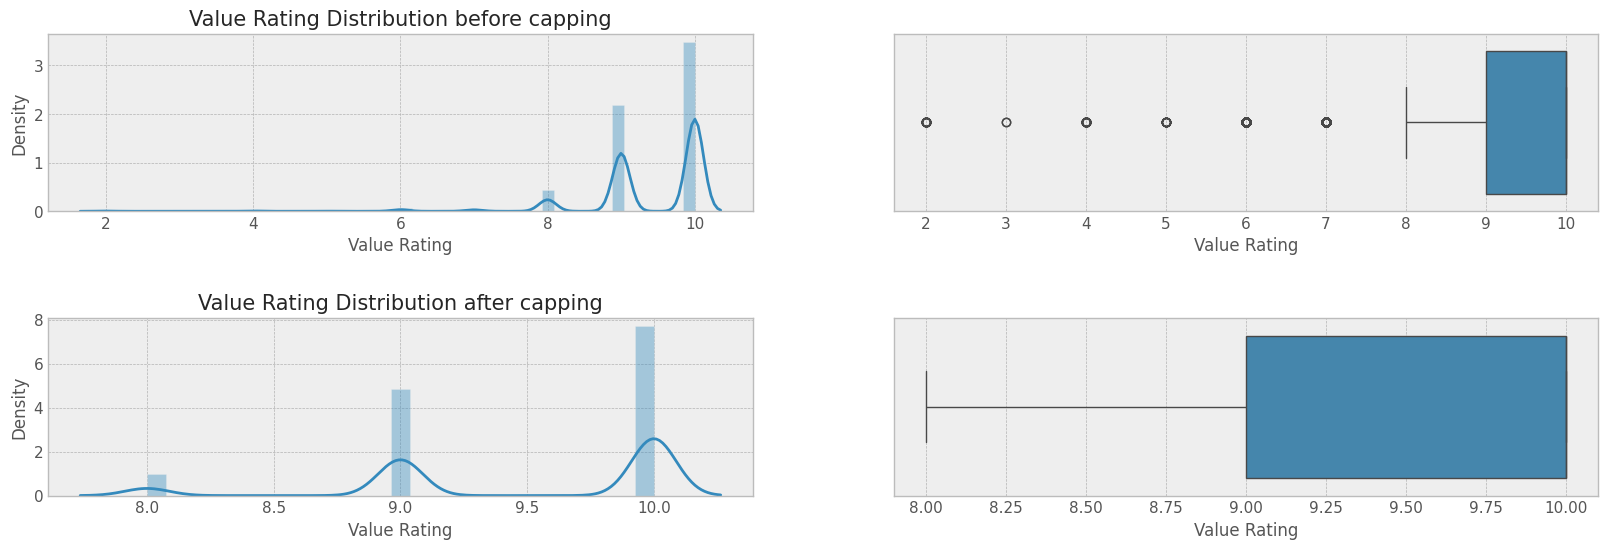

In [277]:
def dist_outliers(original_df, new, cols):
    for col in df_num_non_dummy:
        if col in cols:
          if col != "Price":
            print(col)
            plt.figure(figsize=(20,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col])
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(x=original_df[col])
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col])
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(x=new[col])
            plt.show()
dist_outliers(df, temp, outliers_df.index)

In [158]:
# from autoviz.AutoViz_Class import AutoViz_Class
# import missingno as msno
# import matplotlib.pyplot as plt
# %matplotlib inline
# AV = AutoViz_Class()
# AV.AutoViz(filename="", sep=",", depVar="Price", dfte=df_aggregated, max_cols_analyzed=10)


In [159]:
# from geopy.distance import great_circle
# def distance_to_mid(lat, lon):
#     berlin_centre = (52.5027778, 13.404166666666667)
#     accommodation = (lat, lon)
#     return great_circle(berlin_centre, accommodation).km

# df_aggregated['Distance From Center Cleansed'] = df_aggregated.apply(lambda row: round(distance_to_mid(row['Latitude'], row['Longitude']), 1), axis=1)
# bins = [0, 0.5, 1, 2, 4, 8, 16]
# labels = ["Center", "Cercile1 ", "Cercile2", "Cercile4", "Cercile8", "Cercile16"]

# # Apply pd.cut() to create a new binned column
# df_aggregated["Distance From Center Grouped Cleansed"] = pd.cut(df_aggregated["Distance From Center Cleansed"], bins=bins, labels=labels, include_lowest=True)
# # df_aggregated.drop(columns=["Distance From Center Cleansed"], inplace=True)
# # df_aggregated.drop(columns=["Latitude","Longitude"], inplace=True)
